# Practical 4

**Group composition**: 
- Lucie-Marie BOSCHIAN CAMPANER &bull; [lucie-marie.boschiancampaner@ensiie.fr](mailto:lucie-marie.boschiancampaner@ensiie.fr)
- Khalil BATTIKH &bull; [khalil.battikh@ensiie.fr](mailto:khalil.battikh@ensiie.fr)
- Lucas RODRIGUEZ &bull; [lucas.rodriguez@ensiie.fr](mailto:lucas.rodriguez@ensiie.fr)

**Group ID**: 11

**Author**: *Lucas RODRIGUEZ*

## First steps

In [1]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
import missingno as msno
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import *
from keras_visualizer import visualizer
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import datetime
import tensorflow_addons as tfa
import time
import copy
# Silencing all warnings for a better UX
warnings.filterwarnings("ignore")

# Setting up a fixed random seed for experiment purposes
np.random.seed(1)

The chosen dataset is the following : **Individual household electric power consumption Data Set**.

- Link of the dataset description: https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption
- Direct link to the dataset: https://archive.ics.uci.edu/ml/machine-learning-databases/00235/


**Selected strategy** : The given dataset offers a lot of features and observations. However, a lot of irregularities have been detected by us. We have to perform heavy transformations on the dataset using pre-processing operations.

To do so, we can first think about using Numpy, for matrix-based manipulations. However, we have decided to use Pandas to deal with tabular data more easily then convert the output version into a Numpy matrix as input for our NN model.

In [35]:
# Importing the given dataset
file_name = "data/household_power_consumption.txt"
df = pd.read_csv(filepath_or_buffer=file_name,
                sep=";",
                decimal=".", # Floating point separator for implicit casting
                parse_dates={'dt' : ['Date', 'Time']}, 
                infer_datetime_format=True, 
                low_memory=False, 
                na_values=['nan','?'],
                index_col='dt')

# Making a deep copy for safety reason
df_initial = df.copy(deep=True)

In [36]:
# Reading
df.head(10)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
2006-12-16 17:29:00,3.520,0.522,235.02,15.0,0.0,2.0,17.0
2006-12-16 17:30:00,3.702,0.520,235.09,15.8,0.0,1.0,17.0
2006-12-16 17:31:00,3.700,0.520,235.22,15.8,0.0,1.0,17.0
2006-12-16 17:32:00,3.668,0.510,233.99,15.8,0.0,1.0,17.0


In [37]:
# Some informations about the different columns composing the csv file
df.info()

# General shape of the DataFrame
df.shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


(2075259, 7)

In [38]:
# Statistical description of the final dataset
df.describe().transpose().round(3)

,count,mean,std,min,25%,50%,75%,max
Global_active_power,2049280.0,1.092,1.057,0.076,0.308,0.602,1.528,11.122
Global_reactive_power,2049280.0,0.124,0.113,0.000,0.048,0.100,0.194,1.390
Voltage,2049280.0,240.840,3.240,223.200,238.990,241.010,242.890,254.150
Global_intensity,2049280.0,4.628,4.444,0.200,1.400,2.600,6.400,48.400
Sub_metering_1,2049280.0,1.122,6.153,0.000,0.000,0.000,0.000,88.000
Sub_metering_2,2049280.0,1.299,5.822,0.000,0.000,0.000,1.000,80.000
Sub_metering_3,2049280.0,6.458,8.437,0.000,0.000,1.000,17.000,31.000


The dataset initially contains 2 075 259 rows and 7 columns.

### Dataset description

This archive contains 2 075 259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months).


**Notes**:

1. The quantity $$\boxed{\text{Total consumption} = \Big(\text{global_active_power}\times \frac{1000}{60} - \text{sub_metering_1} - \text{sub_metering_2} - \text{sub_metering_3}\Big)}$$ represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.

2. The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: 


> **A missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.**

---

#### Description of the columns

1. `date`: Date in format dd/mm/yyyy
2. `time`: time in format hh:mm:ss
3. `global_active_power`: household global minute-averaged active power (in kilowatt)
4. `global_reactive_power`: household global minute-averaged reactive power (in kilowatt)
5. `voltage`: minute-averaged voltage (in volt)
6. `global_intensity`: household global minute-averaged current intensity (in ampere)
7. `sub_metering_1`: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
8. `sub_metering_2`: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
9. `sub_metering_3`: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.



---

7 exp. variables


Possible target:
- All seven variables at $t + 1$
- Total consumption at $t + 1$ $\Longrightarrow$ Chosen task


Important to compare:

1. **persistance**: compare with the error you would have if you considerer that the cons did not change


2. **interest** in predicting $t + 2$, $t + 3$, $t + 4$, ...

Graph of average error with respect to prediction window ($t + 2$, $t + 3$, $t + 4$)  (ATTENTION: INCREASING)


$\longrightarrow$ Persistance on the same graph than the average error.


$\longrightarrow$ It has to be compared to the persistance (which is greater than the RNN average error)

---

0. Column 1

---

#### Summary of the situation

- **Task**: 

- **Target**: T

- **Explanatory variables/features**: 

- **Presence of non-linear links between features**: 

- **Missing values (NaN)**: 

### Dataset references & License

**Authors**:
- Georges Hebrail (georges.hebrail '@' edf.fr), Senior Researcher, EDF R&D, Clamart, France
- Alice Berard, TELECOM ParisTech Master of Engineering Internship at EDF R&D, Clamart, France

**License**: Creative Commons Attribution 4.0 International (CC BY 4.0)

In [39]:
# A quick overview of the dataset structure
df.head(10)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
2006-12-16 17:29:00,3.520,0.522,235.02,15.0,0.0,2.0,17.0
2006-12-16 17:30:00,3.702,0.520,235.09,15.8,0.0,1.0,17.0
2006-12-16 17:31:00,3.700,0.520,235.22,15.8,0.0,1.0,17.0
2006-12-16 17:32:00,3.668,0.510,233.99,15.8,0.0,1.0,17.0


## Data pre-processing & Data-cleaning

### Drop duplicates

The original size of the dataframe is:

In [40]:
df.shape

(2075259, 7)

We can handle duplicate rows by using the following instruction `df.drop_duplicates(inplace=True)`.

However, thanks to a first in-depth visual analysis of the dataset, we have pointed out that all of the duplicated lines are full of **`NaN`** values.

Since we have made a dedicated section to handle them, we will not perform the above operation in this practical.

In [41]:
#df.drop_duplicates(inplace=True) # we keep the "keep" argument to its default value : "first"
#df.shape

In [42]:
#df.dropna(how="all", inplace=True)
#df.shape

In [43]:
# We first determine for each column, the number of different values in this column by using the following Pandas method
df.nunique()

Global_active_power      4186
Global_reactive_power     532
Voltage                  2837
Global_intensity          221
Sub_metering_1             88
Sub_metering_2             81
Sub_metering_3             32
dtype: int64

### Drop useless columns

After a quick visual analysis of the given dataset, we can conclude that there isn't any useless columns to be removed.

### Handling missing values (NaN)

In order to train and validate our model, we cannot tolerate the presence of NaN values within the input dataset; we have to remove all of them.

To have a graphical confirmation, we can produce the two bar plots below showing the "distribution" of the missing values among our dataset.

We have successfully eliminated $2075259 - 1906699 = \fbox{168560}$ rows (especially, most of them were rows filled of NaN values (see next section). 

**Remark** : Most of them have been removed thanks to the `drop_duplicate` operation. However, we still have a remaining row at the end. We remove it.

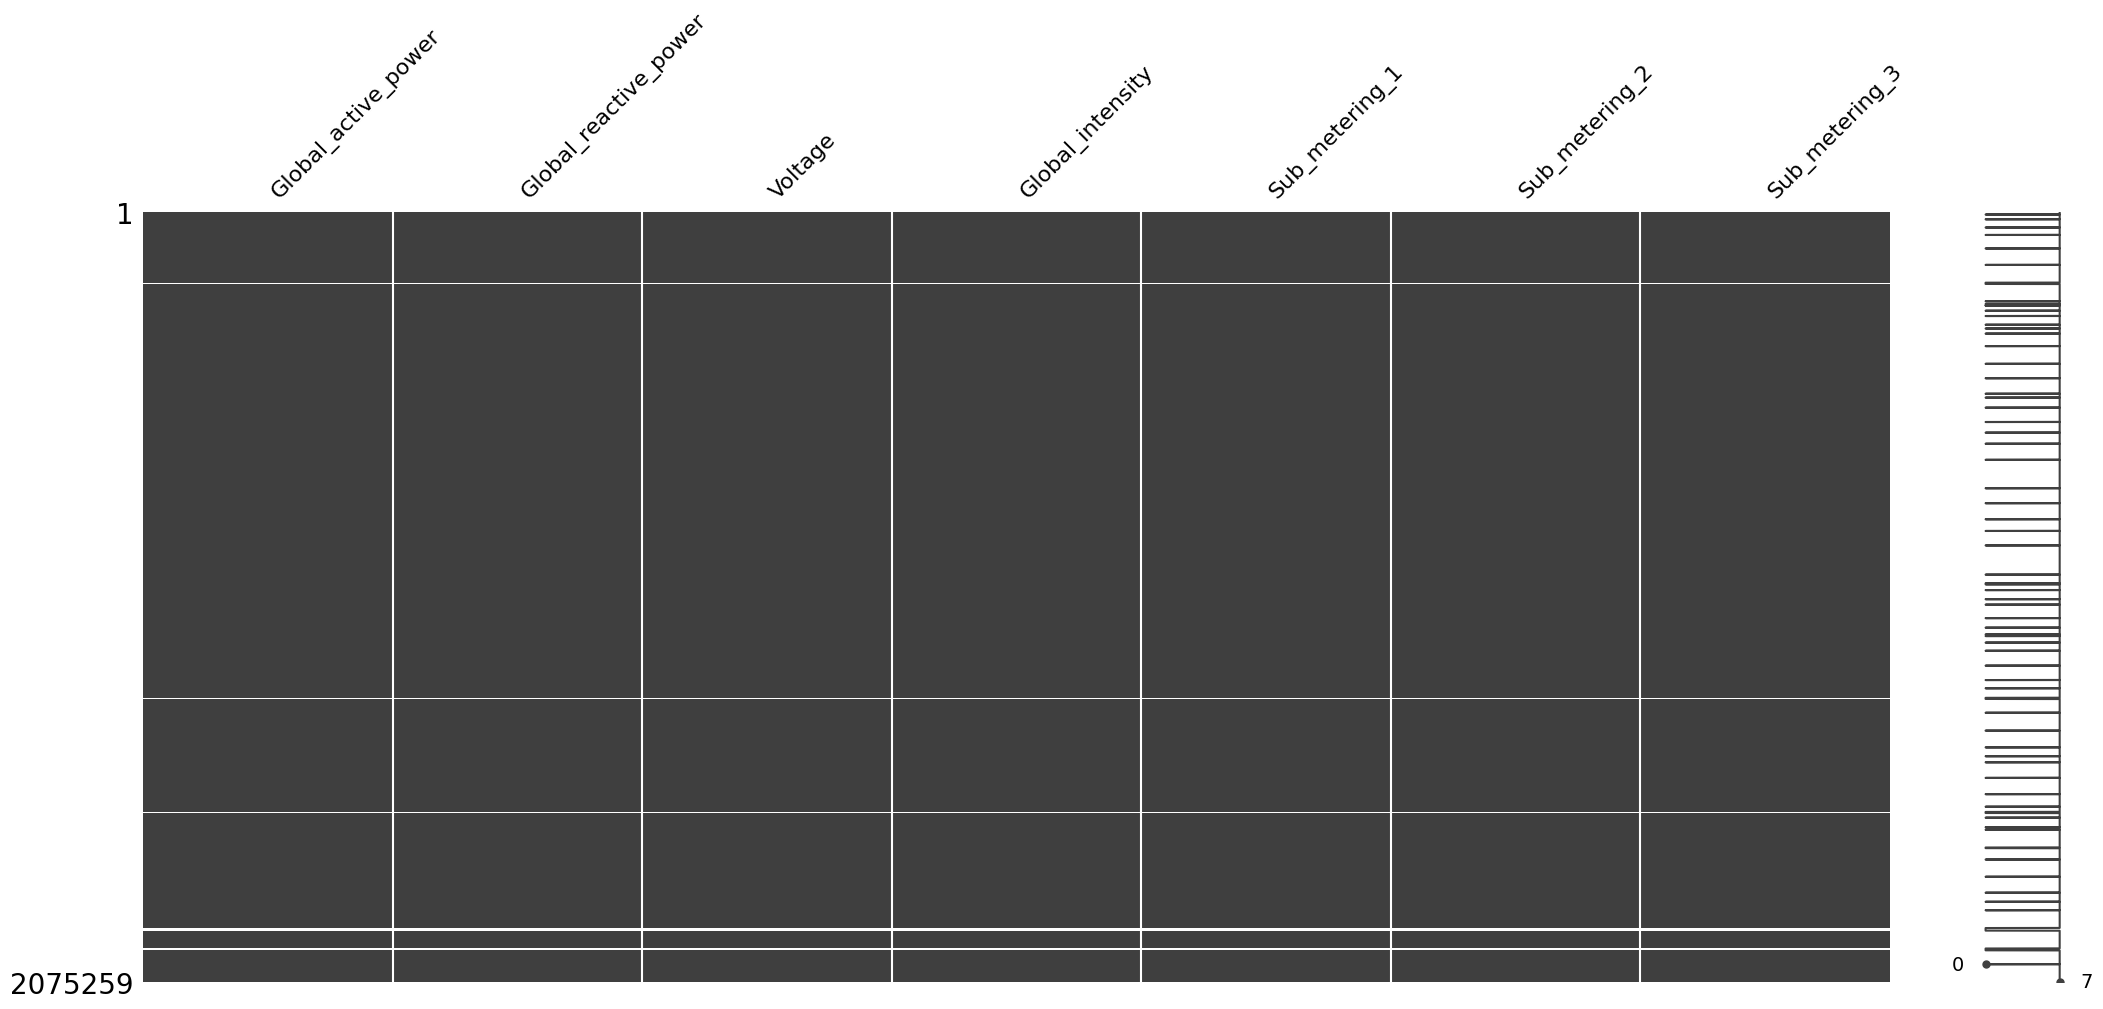

In [44]:
_ = msno.matrix(df)

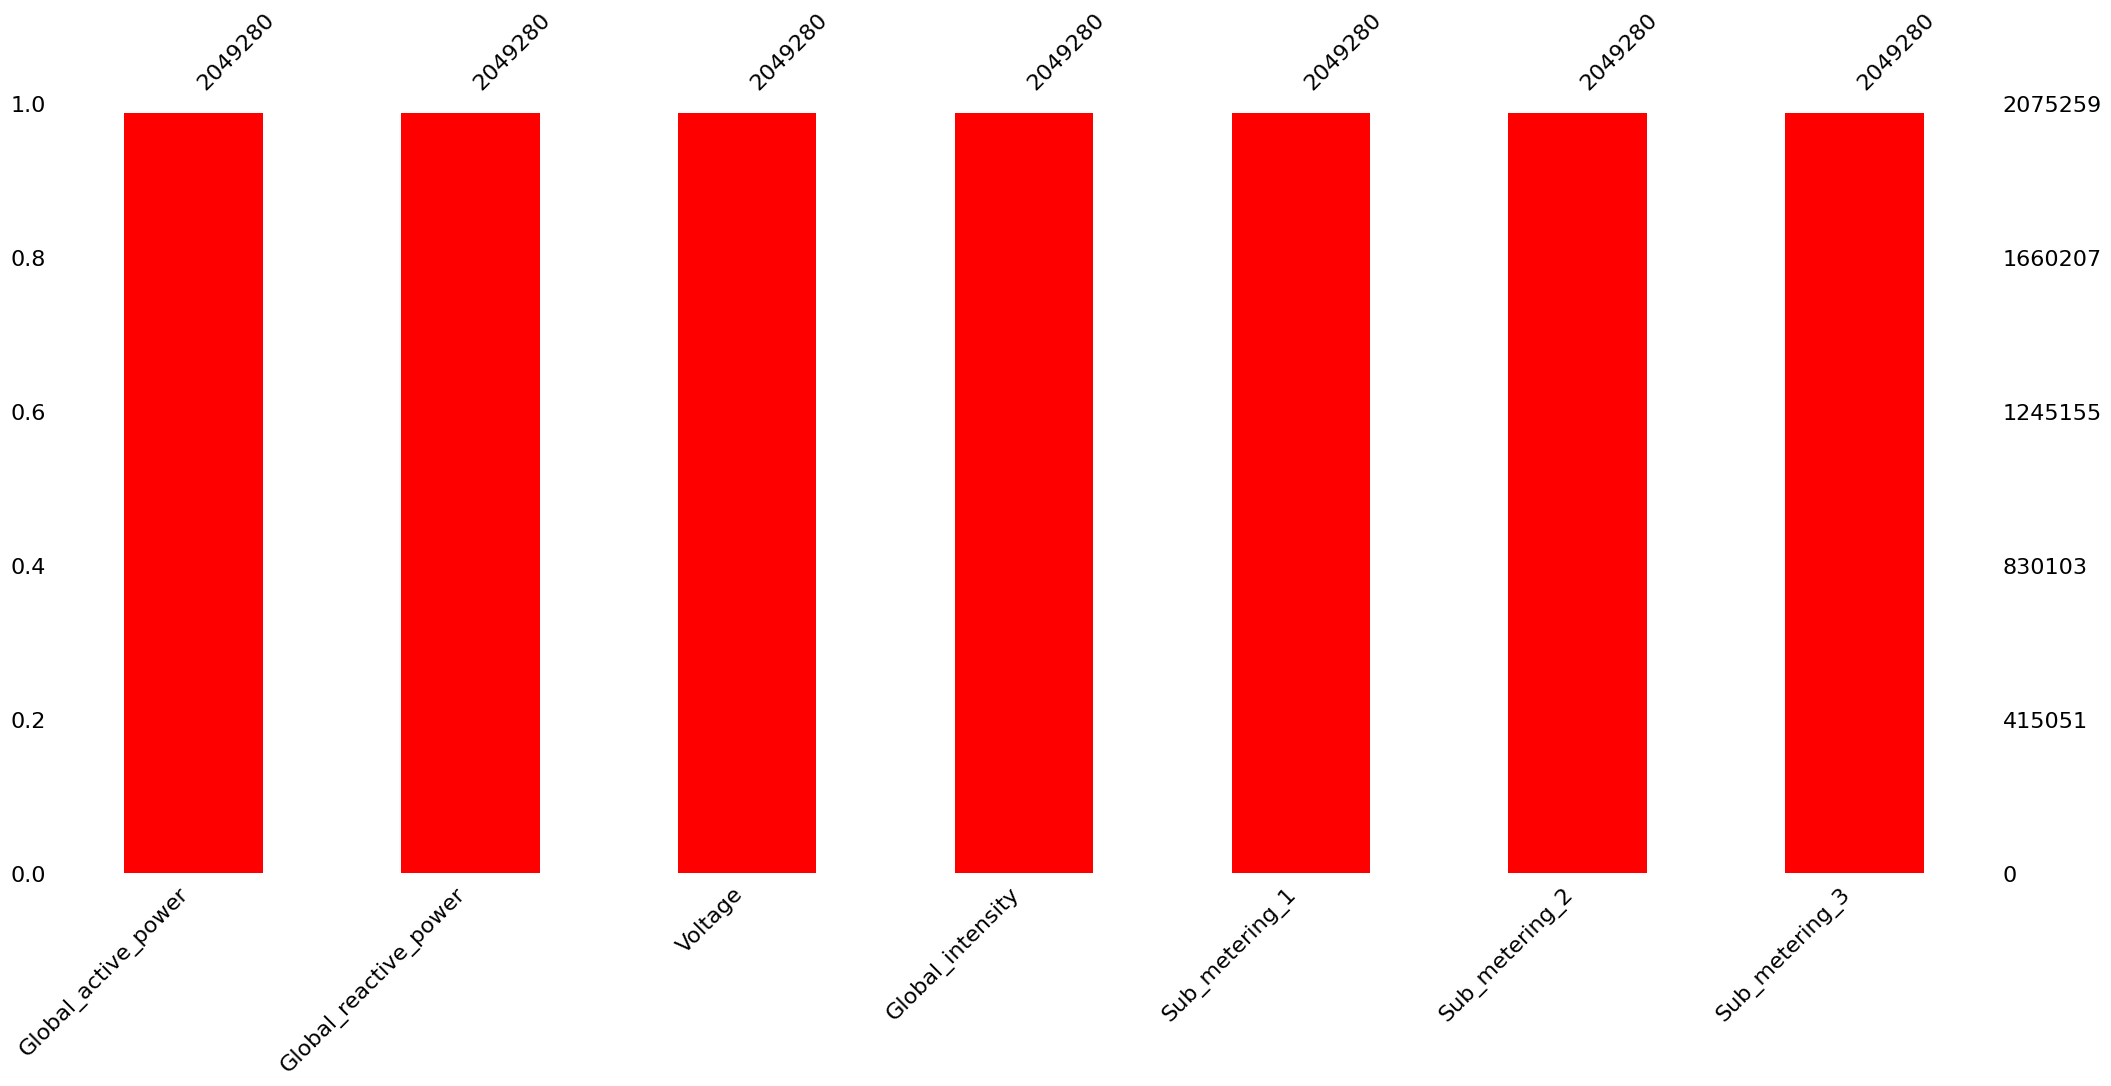

In [45]:
_ = msno.bar(df, color="red")

In [46]:
# Computing the percentage of remaining missing values
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing

Global_active_power      1.251844
Global_reactive_power    1.251844
Voltage                  1.251844
Global_intensity         1.251844
Sub_metering_1           1.251844
Sub_metering_2           1.251844
Sub_metering_3           1.251844
dtype: float64

The other columns have a proportion of NaN lower than $1.3 \ \%$; they contain most of the information of the corresponding feature.

Since the $1.3 \ \%$ represents a really small amount of NaN, the optimal approach to reach our goal is to replace these NaN values by a significant statistical **position** indicator such as : **median** or **mean** value.

$\Longrightarrow$ We choose the **average** value here.

In [47]:
# Removing the NMHC(GT) column
columns_float = list(df.columns)
for c in columns_float:
    df[c].fillna(df[c].mean(), inplace=True) # or .median()

In [48]:
# Computing the percentage of remaining missing values
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing

Global_active_power      0.0
Global_reactive_power    0.0
Voltage                  0.0
Global_intensity         0.0
Sub_metering_1           0.0
Sub_metering_2           0.0
Sub_metering_3           0.0
dtype: float64

There is no **`NaN`** values anymore. We're good to go !

In [49]:
df.head(10)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
2006-12-16 17:29:00,3.520,0.522,235.02,15.0,0.0,2.0,17.0
2006-12-16 17:30:00,3.702,0.520,235.09,15.8,0.0,1.0,17.0
2006-12-16 17:31:00,3.700,0.520,235.22,15.8,0.0,1.0,17.0
2006-12-16 17:32:00,3.668,0.510,233.99,15.8,0.0,1.0,17.0


In [50]:
# Saving the pre-processed dataset on disk
df.to_csv(path_or_buf="data/processed_dataset.csv",
         sep=";",
         header=True)

### Target construction

In [51]:
df["total_consumption"] = df["Global_active_power"]*(1000/60) - (df["Sub_metering_1"] + df["Sub_metering_2"] + df["Sub_metering_3"])

In [52]:
df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,total_consumption
dt,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000
...,...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0,15.766667
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0,15.733333
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0,15.633333


### Features normalization

TODO : référence Lucie-Marie (subsampling) ==> Slides 2, page 46

In [54]:
df_resample = df.resample('h').mean()

In [170]:
df_resample

array([[0.63681623, 0.29573827, 0.33794529, ..., 0.01136636, 0.78241815,
        0.81334629],
       [0.54504495, 0.10335773, 0.33550078, ..., 0.14465183, 0.78267595,
        0.56059147],
       [0.50900588, 0.11007318, 0.28380167, ..., 0.03086863, 0.7741686 ,
        0.58581384],
       ...,
       [0.2385342 , 0.07752906, 0.41839455, ..., 0.00143575, 0.        ,
        0.41302178],
       [0.16153105, 0.07899268, 0.52024552, ..., 0.022972  , 0.        ,
        0.26708923],
       [0.12594772, 0.        , 0.53152393, ..., 0.        , 0.        ,
        0.22374457]])

### Dataset normalization

We can use one of the several scalers available in *scikit-learn*:

- `MinMaxScaler`: subtracts the min value in the feature and dividing by the range of the feature. The MinMaxScaler does not change the shape of the distribution but shrinks the frequency distribution between 0 to 1.  
- `StandardScaler`: rescales the data by subtracting all the entries from the mean value and dividing it by the standard deviation. After a StandardScaler step has been carried out, the mean of the distribution is equal to zero while 67.7% of the distribution falls between -1 and 1
- `RobustScaler` : subtracts the median value from each entry and divides by the interquartile range (IQR) of the feature. Since RobustScaler divides by the interquartile range, the returned frequency distribution penalizes outliers. This makes RobustScaler robust for data with outliers. 


$\Longrightarrow$ Since we have a lot of outliers on many features (see previous sections), we are encouraged to use the `RobustScaler` transform.

In [58]:
# Normalization process using the RobustScaler processor
scaler = MinMaxScaler() # RobustScaler()

# Normalization processes
df_resample = scaler.fit_transform(df_resample)

In [91]:
df_resample

array([[0.63681623, 0.29573827, 0.33794529, ..., 0.01136636, 0.78241815,
        0.81334629],
       [0.54504495, 0.10335773, 0.33550078, ..., 0.14465183, 0.78267595,
        0.56059147],
       [0.50900588, 0.11007318, 0.28380167, ..., 0.03086863, 0.7741686 ,
        0.58581384],
       ...,
       [0.2385342 , 0.07752906, 0.41839455, ..., 0.00143575, 0.        ,
        0.41302178],
       [0.16153105, 0.07899268, 0.52024552, ..., 0.022972  , 0.        ,
        0.26708923],
       [0.12594772, 0.        , 0.53152393, ..., 0.        , 0.        ,
        0.22374457]])

In [95]:
def series_to_supervised(data, n_in: int = 1, n_out: int = 1):
    """
    Function 
    :return:
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    
    dff = pd.DataFrame(data)
    
    cols, names = list(), list()
    
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    for i in range(0, n_out):
        cols.append(dff.shift(i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]        
        
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        agg.dropna(inplace=True)
        return agg

In [102]:
r = series_to_supervised(df_resample)

In [103]:
r

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.636816,0.295738,0.337945,0.631157,0.0,0.011366,0.782418,0.813346,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676,0.560591
2,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676,0.560591,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169,0.585814
3,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169,0.585814,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809,0.572244
4,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809,0.572244,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917,0.503143
5,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917,0.503143,0.322555,0.072536,0.495847,0.323529,0.0,0.002872,0.205723,0.484145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34584,0.146652,0.278476,0.560980,0.147298,0.0,0.020459,0.000000,0.243775,0.248876,0.079294,0.431003,0.240794,0.0,0.000000,0.597061,0.228796
34585,0.248876,0.079294,0.431003,0.240794,0.0,0.000000,0.597061,0.228796,0.225194,0.069350,0.448732,0.219393,0.0,0.000000,0.000000,0.391520
34586,0.225194,0.069350,0.448732,0.219393,0.0,0.000000,0.000000,0.391520,0.238534,0.077529,0.418395,0.235055,0.0,0.001436,0.000000,0.413022
34587,0.238534,0.077529,0.418395,0.235055,0.0,0.001436,0.000000,0.413022,0.161531,0.078993,0.520246,0.158178,0.0,0.022972,0.000000,0.267089


In [104]:
a = list(range(df_resample.shape[1], 2*df_resample.shape[1] - 1))
r.drop(r.columns[a], axis=1, inplace=True)

In [105]:
r

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var8(t)
1,0.636816,0.295738,0.337945,0.631157,0.0,0.011366,0.782418,0.813346,0.560591
2,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676,0.560591,0.585814
3,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169,0.585814,0.572244
4,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809,0.572244,0.503143
5,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917,0.503143,0.484145
...,...,...,...,...,...,...,...,...,...
34584,0.146652,0.278476,0.560980,0.147298,0.0,0.020459,0.000000,0.243775,0.228796
34585,0.248876,0.079294,0.431003,0.240794,0.0,0.000000,0.597061,0.228796,0.391520
34586,0.225194,0.069350,0.448732,0.219393,0.0,0.000000,0.000000,0.391520,0.413022
34587,0.238534,0.077529,0.418395,0.235055,0.0,0.001436,0.000000,0.413022,0.267089


### $X$/$Y$ dataset split

We now have to split the main dataset into $X$ and $Y$ dataframes.

As a reminder:
- $X$ represents the features matrix
- $Y$ represents the target variable (as a vector or Pandas Series to be more precise) $\Longrightarrow$ `var8(t)`.

In [107]:
X = r.copy() # X as a deep copy for security reason
Y = X.pop("var8(t)")

In [111]:
# Features
X.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1)
1,0.636816,0.295738,0.337945,0.631157,0.0,0.011366,0.782418,0.813346
2,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676,0.560591
3,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169,0.585814
4,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809,0.572244
5,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917,0.503143


In [112]:
# Target
Y.head()

1    0.560591
2    0.585814
3    0.572244
4    0.503143
5    0.484145
Name: var8(t), dtype: float64

### Handling outliers

<p style="color:red"> 
    <b>WARNING</b>: This step has to be performed <b>RIGHT AFTER</b> the train/test/validation split <b>AND ONLY</b> on the train set.
</p>

In order to check the presence of outliers within our dataset, we analyze the box-plot of each column.

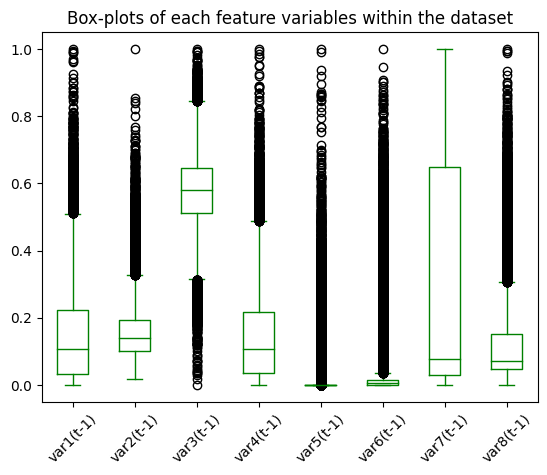

In [137]:
X.plot(kind="box",
       title="Box-plots of each feature variables within the dataset",
       color="green", xlabel=None)
_ = plt.xticks(rotation=45)

At first sight, we wanted to perform some data pre-processing on the outliers. Our first track was to implement the **Winsorize method** which rescales the observations and tries to replace the outliers by "normal values".

However, since we don't want to facilitate **over-fitting** potential behaviors and as we also want to introduce noise in the coming steps within the feedforwarding step, we do not pursue on this track.

IndexError: index 8 is out of bounds for axis 0 with size 8

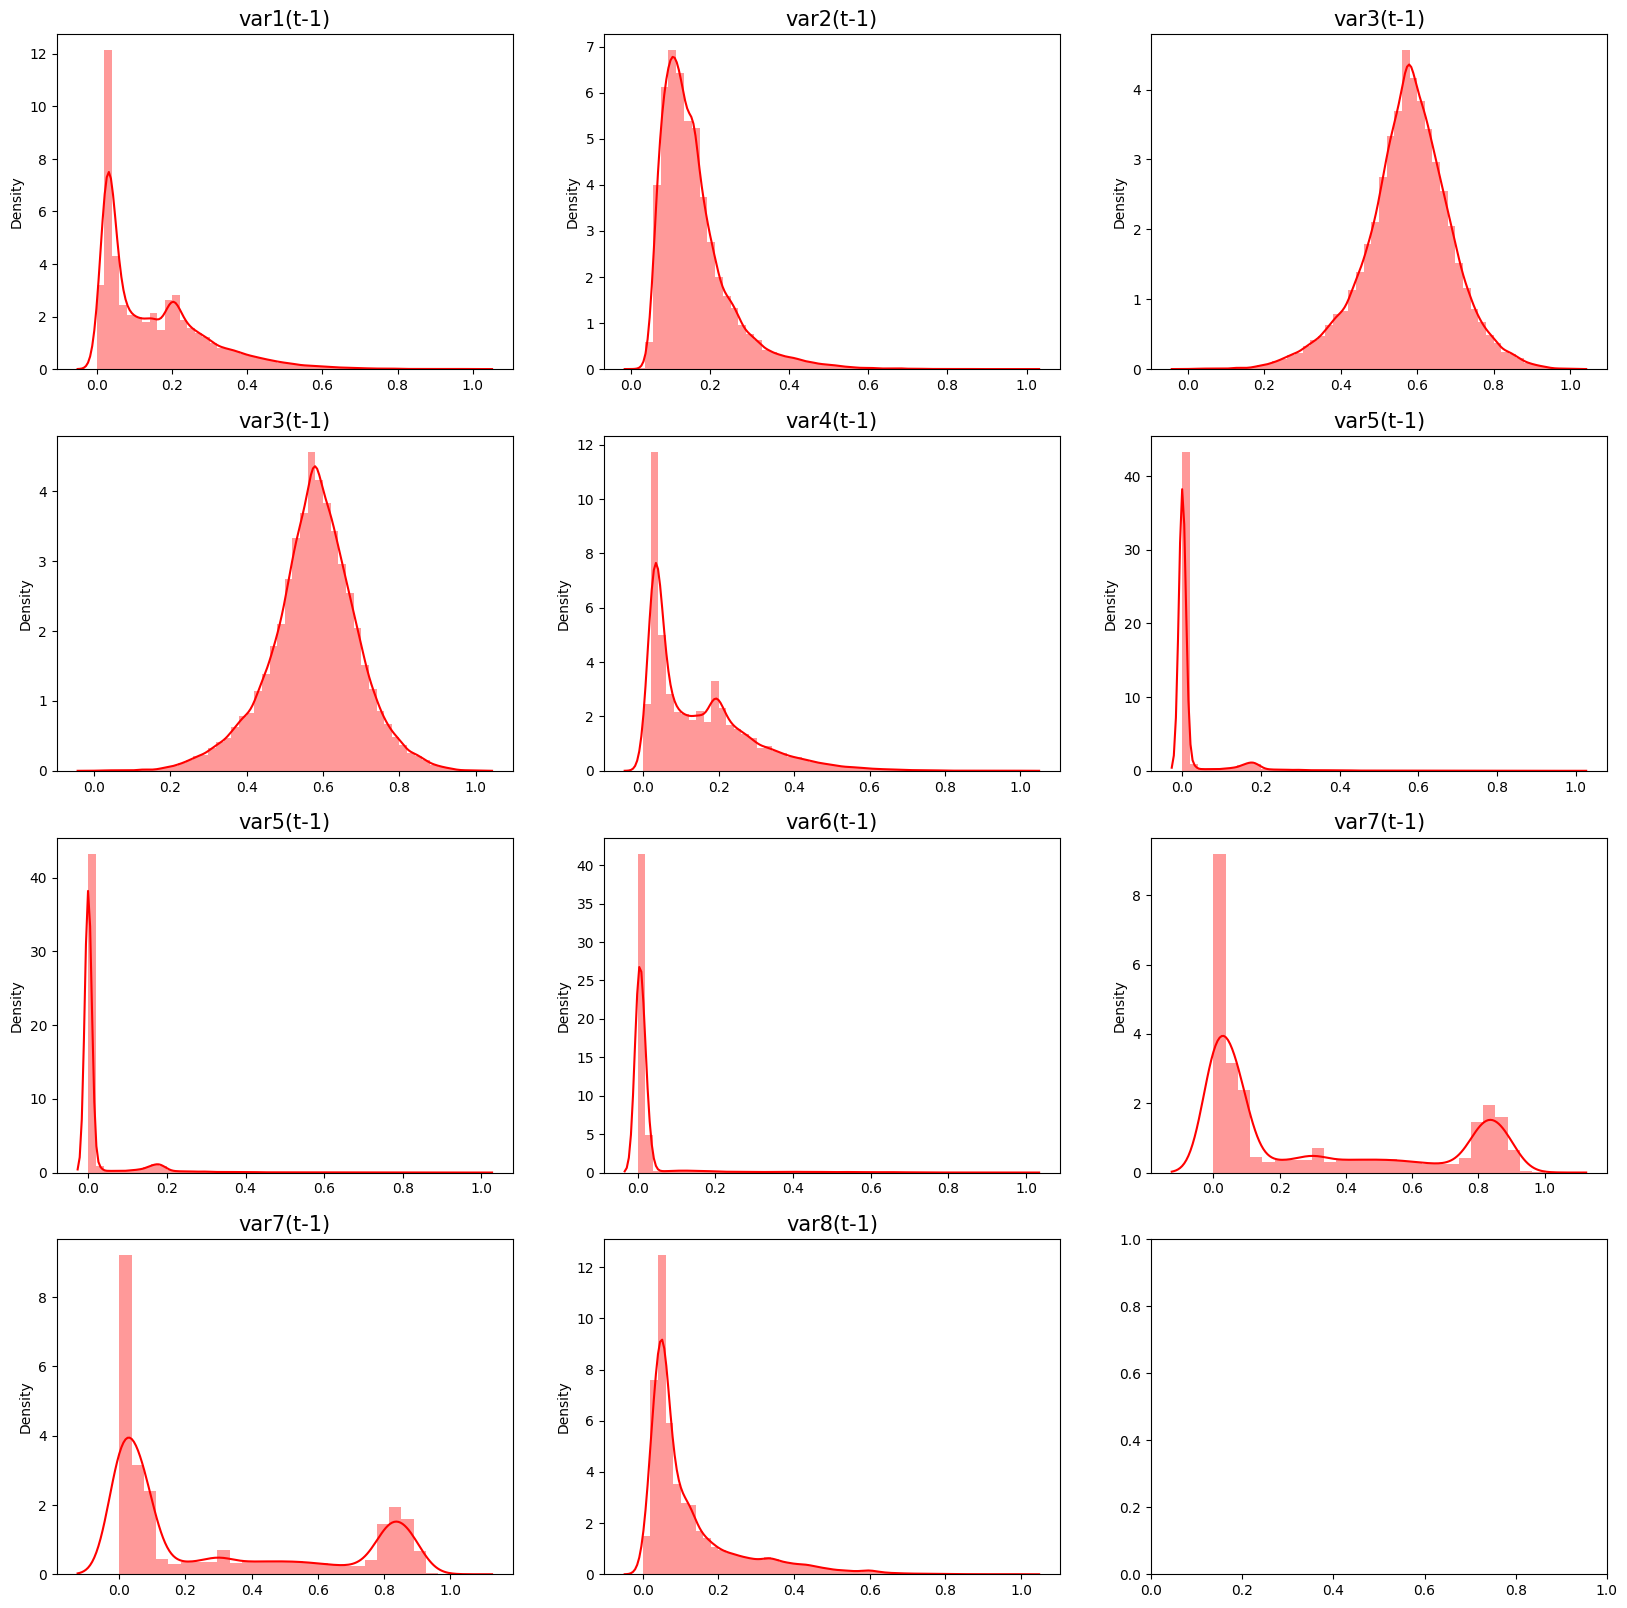

In [115]:
# Plotting distribution plots for each column
fig, ax = plt.subplots(4, 3, figsize=(20, 20))
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        g = sns.distplot(X[X.columns[i*2+j]], ax=ax[i][j], color="red")
        g.set(xlabel=None)
        g.set_title(X[X.columns[i*2+j]].name, fontsize = 15)

### Handling high-correlated data

Linear regression cannot perform a good fitting process with highly-correlated features.
Given a specific threshold, we will remove the most correlated variables in order to obtain consistent results.

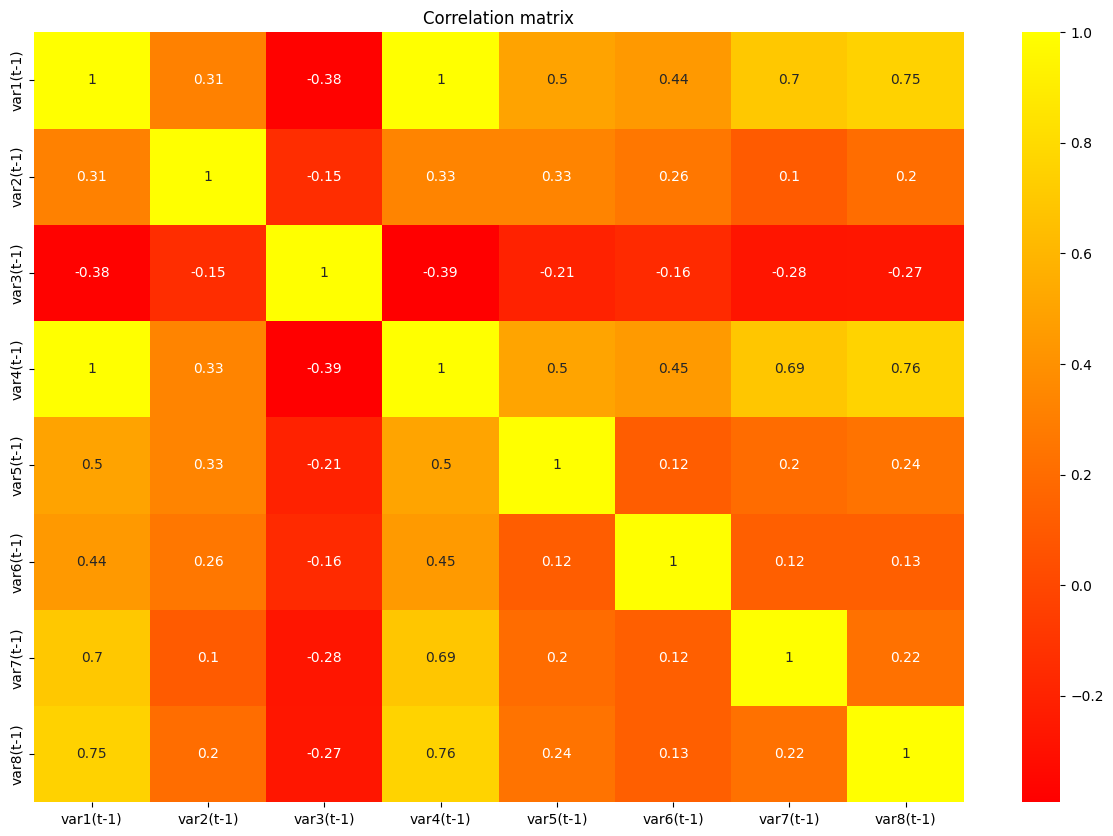

In [185]:
# Computing and plotting the correlation matrix of the final dataset
plt.figure(figsize=(15, 10))
correlation_matrix = X.abs().corr() #.abs()
sns.heatmap(correlation_matrix, annot=True, cmap="autumn")
plt.title("Correlation matrix")
plt.show()

We can briefly check that there are some variables with a high correlation facotr.
However, the general trend seems to point out an absence of linear link between the different variables.

### Train/test dataset split

In order to monitor the model's capacity, we are conducting a train/test/validation split.

<p style="color:red">
    <b>WARNING</b> : Since we are dealing with time-series data, we cannot tolerate any shuffle process within the train/test/validation split.
</p>

In [158]:
# Size setting
SIZE_SAMPLE_TEST = 0.4
#SIZE_SAMPLE_VALIDATION = 0.2

# Creation of training and testing dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size = SIZE_SAMPLE_TEST,
                                                   shuffle=False)

In [159]:
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, 
                                                  test_size=0.5,
                                                 shuffle=False)

In [173]:
X_train.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1)
1,0.270068,0.192682,0.396765,0.262793,0.0,0.011366,0.782418,0.215034
2,0.270068,0.103358,0.396765,0.262793,0.0,0.014716,0.782676,0.215034
3,0.270068,0.110073,0.396765,0.262793,0.0,0.014716,0.774169,0.215034
4,0.270068,0.096987,0.396765,0.262793,0.0,0.000000,0.778809,0.215034
5,0.270068,0.099010,0.434417,0.262793,0.0,0.008973,0.784996,0.215034


In [172]:
X_test.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1)
20753,0.187736,0.073741,0.614315,0.178742,0.000000,0.000000,0.761021,0.069758
20754,0.106631,0.161171,0.522419,0.108680,0.000000,0.012204,0.206497,0.112034
20755,0.289996,0.138872,0.573108,0.278694,0.000000,0.000000,0.893271,0.197717
20756,0.295278,0.158760,0.552214,0.285031,0.164714,0.011845,0.849961,0.087145
20757,0.226752,0.111408,0.627250,0.215208,0.023432,0.000000,0.905646,0.068742


In [171]:
X_val.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1)
27671,0.036215,0.163969,0.874716,0.036107,0.0,0.014716,0.032483,0.050252
27672,0.054957,0.152088,0.844430,0.053324,0.0,0.014716,0.031709,0.082198
27673,0.082539,0.076840,0.760679,0.076160,0.0,0.000000,0.031709,0.139594
27674,0.203893,0.214249,0.579502,0.199546,0.0,0.000000,0.030162,0.345269
27675,0.341162,0.181489,0.592487,0.326518,0.0,0.000000,0.645785,0.368259


#### Outliers detection & correction

In [177]:
def apply_outliers_detect_col(col):
    """
    Function returning an outliers-corrected column from the initial column : col
    :param col: Initial column
    """
    return winsorize(col, limits=[0.1, 0.2])

def apply_outliers_detect(df):
    """
    Function returnin an outliers-corrected dataframe from the initial dataframe : df
    :param df: Initial dataframe
    """
    return df.apply(apply_outliers_detect_col, axis = 0)

# Applying the filtering of outliers on the train dataset ONLY
X_train = apply_outliers_detect(X_train)

In [163]:
X_train

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1)
1,0.270068,0.192682,0.396765,0.262793,0.0,0.011366,0.782418,0.215034
2,0.270068,0.103358,0.396765,0.262793,0.0,0.014716,0.782676,0.215034
3,0.270068,0.110073,0.396765,0.262793,0.0,0.014716,0.774169,0.215034
4,0.270068,0.096987,0.396765,0.262793,0.0,0.000000,0.778809,0.215034
5,0.270068,0.099010,0.434417,0.262793,0.0,0.008973,0.784996,0.215034
...,...,...,...,...,...,...,...,...
20748,0.037158,0.073526,0.605972,0.039933,0.0,0.000000,0.030162,0.063402
20749,0.044936,0.092596,0.581912,0.047107,0.0,0.007179,0.030936,0.071036
20750,0.215732,0.134008,0.586407,0.210187,0.0,0.005384,0.550657,0.184585
20751,0.270068,0.092208,0.546485,0.262793,0.0,0.000359,0.784996,0.215034


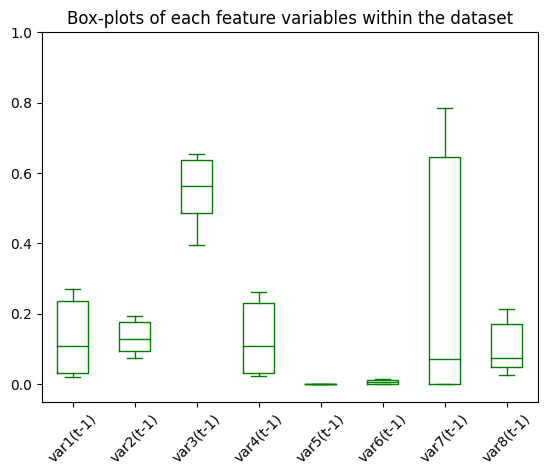

In [175]:
X_train.plot(kind="box",
       title="Box-plots of each feature variables within the dataset",
       color="green", xlabel=None)
_ = plt.xticks(rotation=45)
_ = plt.ylim([-0.05, 1])

We observe the total absence of outliers.

## LSTM/NN model design

### Preliminary steps

In [906]:
"""
Available callbacks:
- tfa.callbacks.TQDMProgressBar()
- livelossplot.PlotLossesKeras()
- keras_tqdm() <-- to be avoided
"""

# Initialize tqdm callback with default parameters
tqdm_callback = tfa.callbacks.TQDMProgressBar()

# Simple assertion for technical reason
tf.keras.models.Sequential == tf.keras.Sequential

True

### Model's creation and parametrization

In [907]:
# Creation of the neural network
model = Sequential()

# Input layer
model.add(Dense(units=12, input_dim=X.shape[1], activation="relu"))
# WARNING: the parameter input_dim has to be exactly equal to the number of column of X_train

# Hidden layers
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))

# Output layer
model.add(Dense(1, activation='linear'))

#### Model's architecture graphical representation

We can visualize the model graphically as shown below:

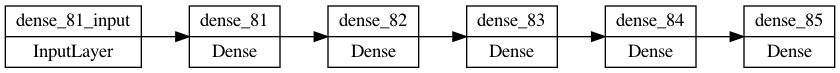

In [908]:
plot_model(model,
           to_file="img/graph_nn_1_alt.png",
           rankdir="LR")

A better graphical approach is:

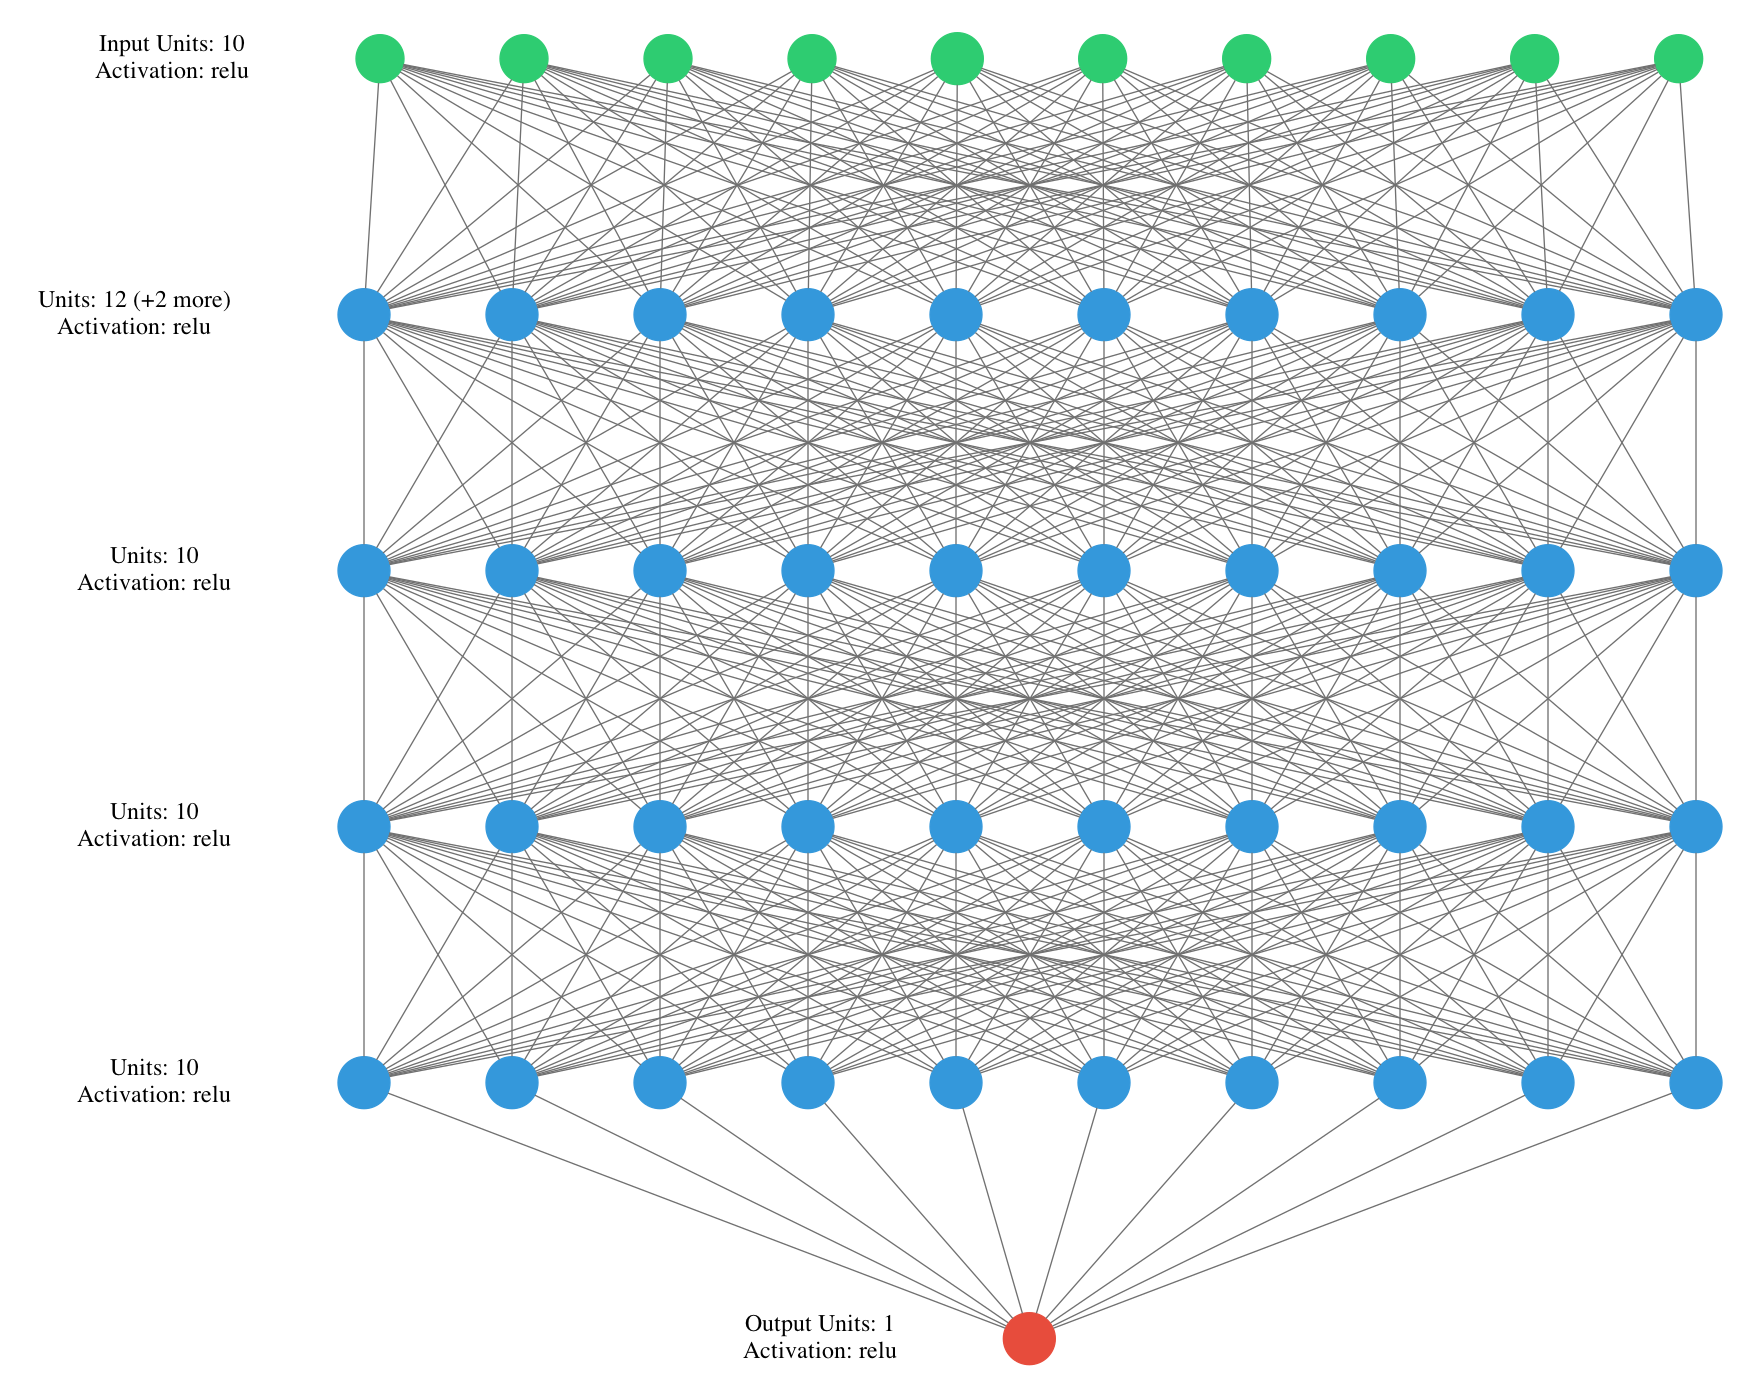

In [909]:
visualizer(model, 
           filename="img/graph_nn_1", 
           format='png', 
           view=False
          )
Image("img/graph_nn_1.png")

#### Optimizer's choice


In our neural network (NN), the optimizer has been kept unchanged (Adam algorithm with custom $\eta$ and specific cost function).


#### Model's parameters


**References**:

- https://towardsdatascience.com/understanding-learning-rates-and-how-it-improves-performance-in-deep-learning-d0d4059c1c10

We now have to compile and fit the model with the training dataset:

In [932]:
# Definition of the different arguments
eta = 2e-3 # generally between 1e-2 and 1e-4
NB_EPOCHS = 30 #150

# Setting up the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=eta)

# Early Stopping
#es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="max")

# Compiling the model
model.compile(loss='mae', 
              optimizer=optimizer, 
              metrics=["mse", "mae"]
             )
type(model)
# The metric called `accuracy` is meaningless in our case because of the linear regression situation. 
# In fact, the accuracy is only meaningful in classification problems).

keras.engine.sequential.Sequential

In [911]:
# Fit step of the model
fit_start = time.time()
history = model.fit(x=X_train, y=Y_train, 
                    epochs=NB_EPOCHS,
                    validation_data=(X_test, Y_test),
                    #validation_split=0.3, # mettre validation_data avec X_test, Y_test
                    verbose=0,
                    callbacks=[tqdm_callback], # [es, tqdm_callback],
                    batch_size=10,
                    #workers=8,
                    #use_multiprocessing=True
                   )
fit_end = time.time()
fit_dur = np.abs(fit_end - fit_start)

Training:   0%|     0/30 ETA: ?s,  ?epochs/s

Epoch 1/30


0/655                             ETA: ?s - 

Epoch 2/30


0/655                             ETA: ?s - 

Epoch 3/30


0/655                             ETA: ?s - 

Epoch 4/30


0/655                             ETA: ?s - 

Epoch 5/30


0/655                             ETA: ?s - 

Epoch 6/30


0/655                             ETA: ?s - 

Epoch 7/30


0/655                             ETA: ?s - 

Epoch 8/30


0/655                             ETA: ?s - 

Epoch 9/30


0/655                             ETA: ?s - 

Epoch 10/30


0/655                             ETA: ?s - 

Epoch 11/30


0/655                             ETA: ?s - 

Epoch 12/30


0/655                             ETA: ?s - 

Epoch 13/30


0/655                             ETA: ?s - 

Epoch 14/30


0/655                             ETA: ?s - 

Epoch 15/30


0/655                             ETA: ?s - 

Epoch 16/30


0/655                             ETA: ?s - 

Epoch 17/30


0/655                             ETA: ?s - 

Epoch 18/30


0/655                             ETA: ?s - 

Epoch 19/30


0/655                             ETA: ?s - 

Epoch 20/30


0/655                             ETA: ?s - 

Epoch 21/30


0/655                             ETA: ?s - 

Epoch 22/30


0/655                             ETA: ?s - 

Epoch 23/30


0/655                             ETA: ?s - 

Epoch 24/30


0/655                             ETA: ?s - 

Epoch 25/30


0/655                             ETA: ?s - 

Epoch 26/30


0/655                             ETA: ?s - 

Epoch 27/30


0/655                             ETA: ?s - 

Epoch 28/30


0/655                             ETA: ?s - 

Epoch 29/30


0/655                             ETA: ?s - 

Epoch 30/30


0/655                             ETA: ?s - 

### Evaluation

In [912]:
print(f"Fitting duration: {fit_dur} sec")
# To be called right AFTER fitting operation
METRICS = model.metrics_names
print(f"Metrics available: {METRICS}")

Fitting duration: 26.979540824890137 sec
Metrics available: ['loss', 'mse', 'mae']


In [928]:
# Gathering the output data from the fitting set
history_df = pd.DataFrame(history.history)
history_df.head(10)

,loss,mse,mae,val_loss,val_mse,val_mae
0,5.321812,71.038628,5.321812,1.409129,3.542069,1.409129
1,1.172029,2.676520,1.172029,0.851247,1.443665,0.851247
2,0.779058,1.193376,0.779058,0.675523,0.860269,0.675523
3,0.684657,0.896731,0.684657,0.660354,0.767583,0.660354
4,0.645225,0.771722,0.645225,0.653662,0.727712,0.653662
5,0.604470,0.713128,0.604470,0.549069,0.603112,0.549069
6,0.598473,0.676945,0.598473,0.557831,0.614889,0.557831
7,0.550893,0.607101,0.550893,0.638540,0.733874,0.638540
8,0.534690,0.571729,0.534690,0.489035,0.502954,0.489035
9,0.527782,0.560702,0.527782,0.462604,0.458437,0.462604


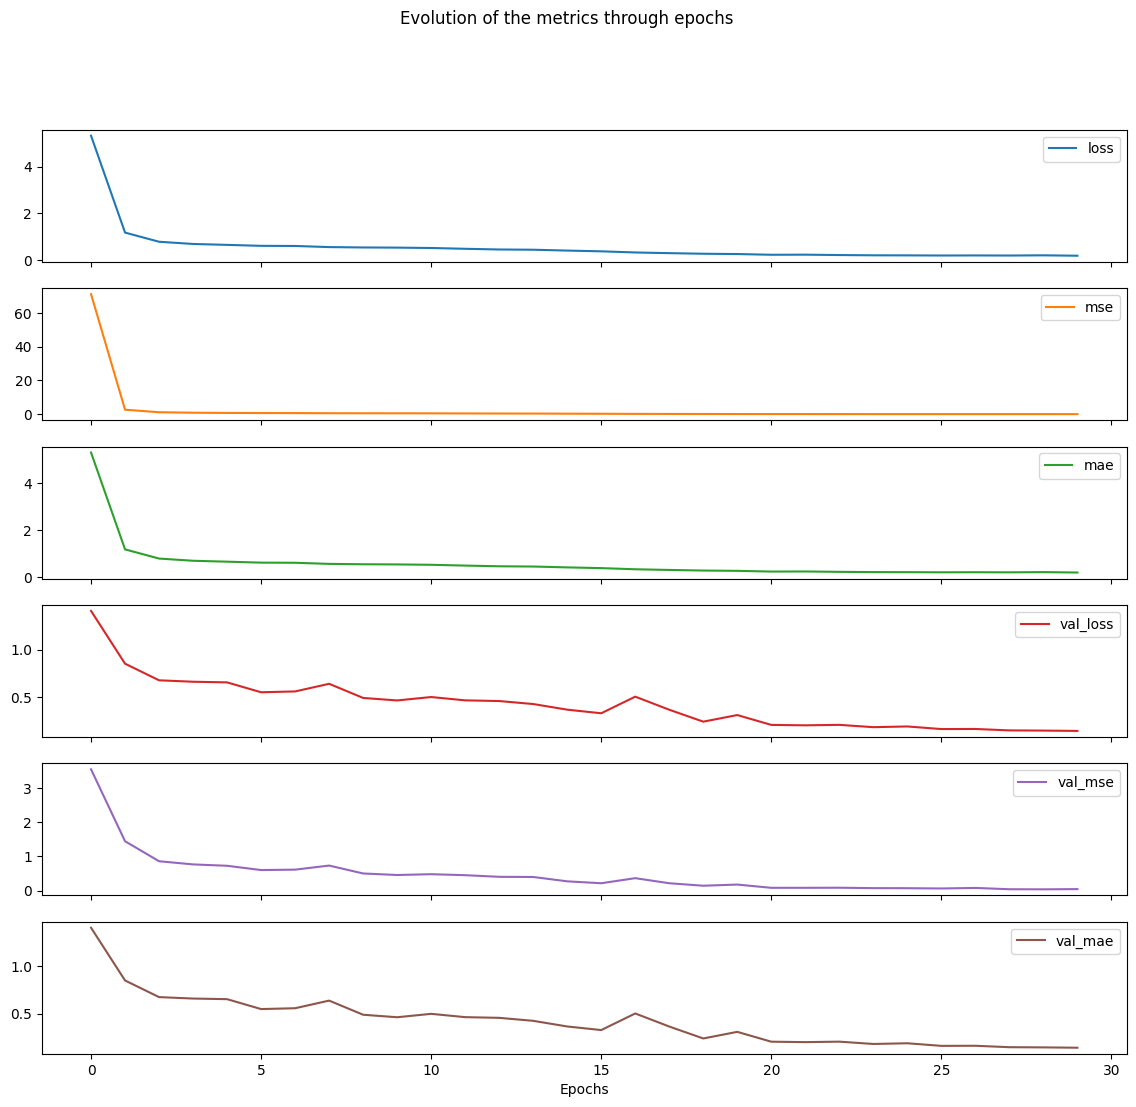

In [930]:
ax = history_df.plot(subplots=True, 
                    figsize=(14,12), 
                    #sharex=True,
                    title="Evolution of the metrics through epochs", 
                    #layout=(4,2)
                    )
_ = [ax[k].set_xlabel("Epochs") for k in range(len(ax))]

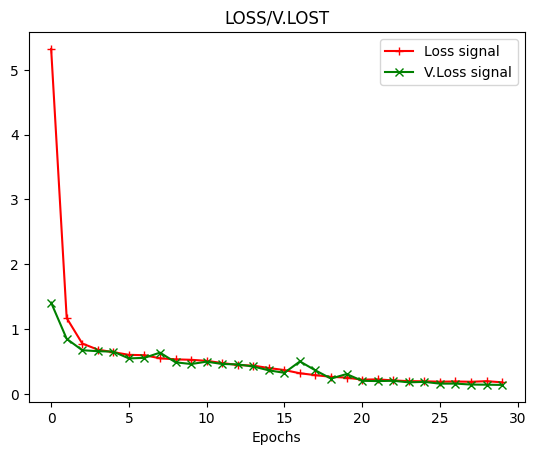

In [915]:
# Plotting the loss and validation loss
plt.plot(history_df['loss'], "r+-", label='Loss signal')
plt.plot(history_df['val_loss'], "gx-", label='V.Loss signal')
plt.title("LOSS/V.LOST")
plt.xlabel("Epochs")
plt.legend()

In [929]:
# Evaluation on the test set with the same parameters (batch_size equal)
scores = model.evaluate(X_test, Y_test,
                       batch_size=10,
                       verbose=0,
                       callbacks=[tqdm_callback])

# Printing in a more human-friendly interface the different scores
s = {k[1]:scores[0] for k in enumerate(METRICS)}
print(f"Statistics ==> {s}")

0/281                   ETA: ?s - Evaluating

Statistics ==> {'loss': 0.1403432935476303, 'mse': 0.1403432935476303, 'mae': 0.1403432935476303}


In [920]:
# Prediction on the test set
Y_pred = model.predict(X_test).flatten()

88/88 [==============================] - 0s 890us/step


In [921]:
# Computing the main statistical indicators
AE = np.abs(Y_pred - Y_test)
SE = np.square(Y_pred - Y_test) 
RSE = np.sqrt(SE)
MAE = np.mean(AE)
MSE = np.mean(SE)
RMSE = np.sqrt(MSE)
print(f"Statistics : \nMAE \t = {MAE}\nMSE \t = {MSE}\nRMSE \t = {RMSE}")

Statistics : 
MAE 	 = 0.1403432820319082
MSE 	 = 0.047079707103610514
RMSE 	 = 0.21697858673982212


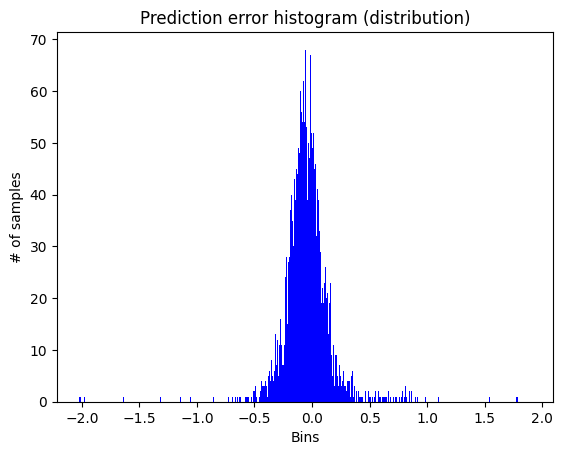

In [976]:
_ = plt.hist(Y_pred - Y_test, bins = 600, color="blue")
_ = plt.title("Prediction error histogram (distribution)")
_, _ = plt.xlabel("Bins"), plt.ylabel("# of samples")

In [923]:
# Within k-sigma ranges where k \in {1, 2, 3}
within_sigma = {k:np.sum(np.abs(Y_pred - Y_test.to_numpy()) < k*RMSE) for k in [0.5, 1, 2, 3, 6]}
print(within_sigma)

{0.5: 1480, 1: 2325, 2: 2702, 3: 2763, 6: 2798}


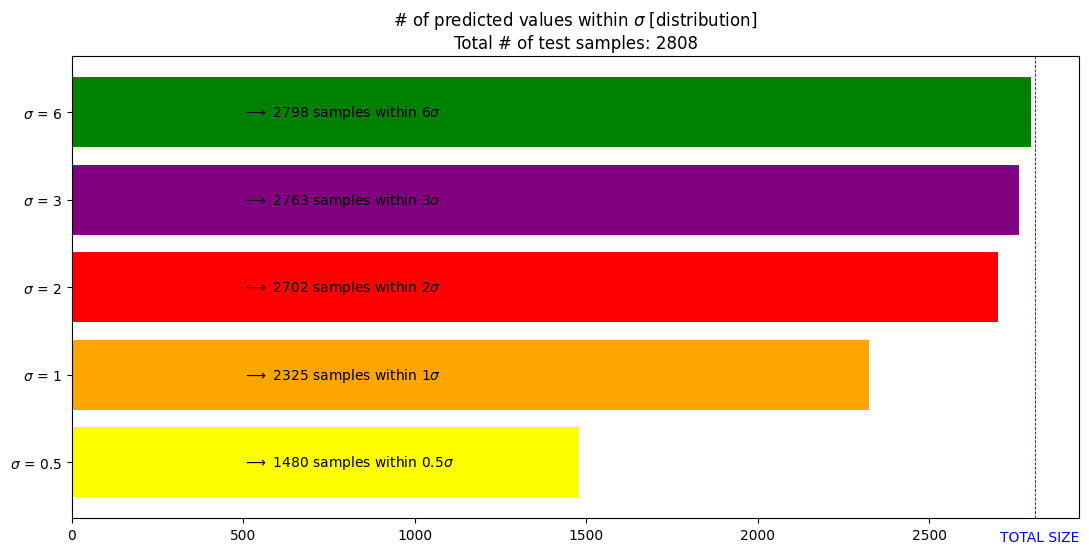

In [924]:
plt.figure(figsize=(13, 6))
_ = plt.barh(range(len(within_sigma)), 
            list(within_sigma.values()), 
            align='center', color=["yellow", "orange", "red", "purple", "green"])
_ = plt.yticks(range(len(within_sigma)), 
               list(["$\sigma$ = " + str(k) for k in within_sigma.keys()]))
for i, v in enumerate(within_sigma.values()):
    _ = plt.text(500, i, f"$\longrightarrow$ {v} samples within {list(within_sigma)[i]}$\sigma$", color='black', va="center")

plt.axvline(x=Y_test.shape[0], color='b', lw=0.6, ls="--")
plt.text(x=Y_test.shape[0] - 100, y = -0.9, s="TOTAL SIZE", color="blue")
_ = plt.title(f"# of predicted values within $\sigma$ [distribution]\nTotal # of test samples: {Y_test.shape[0]}")

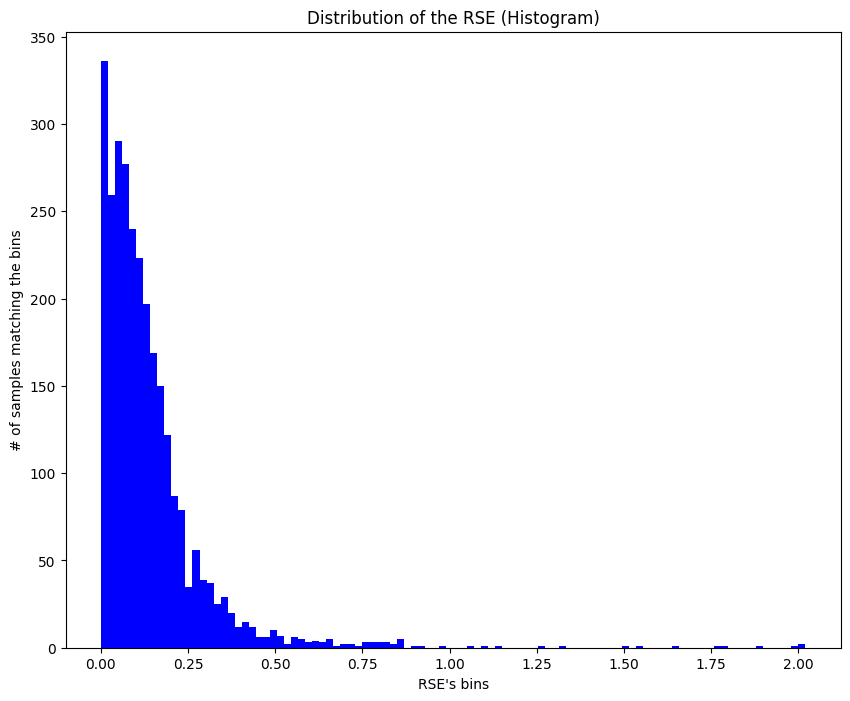

In [925]:
# Histogram of errors
plt.figure(figsize=(10, 8))
plt.title("Distribution of the RSE (Histogram)")
_, _, _ = (plt.hist(RSE, bins=100, color="blue"),
           plt.xlabel("RSE's bins"),
           plt.ylabel("# of samples matching the bins")
          )

Thanks to the previous cell, we can easily recover the number

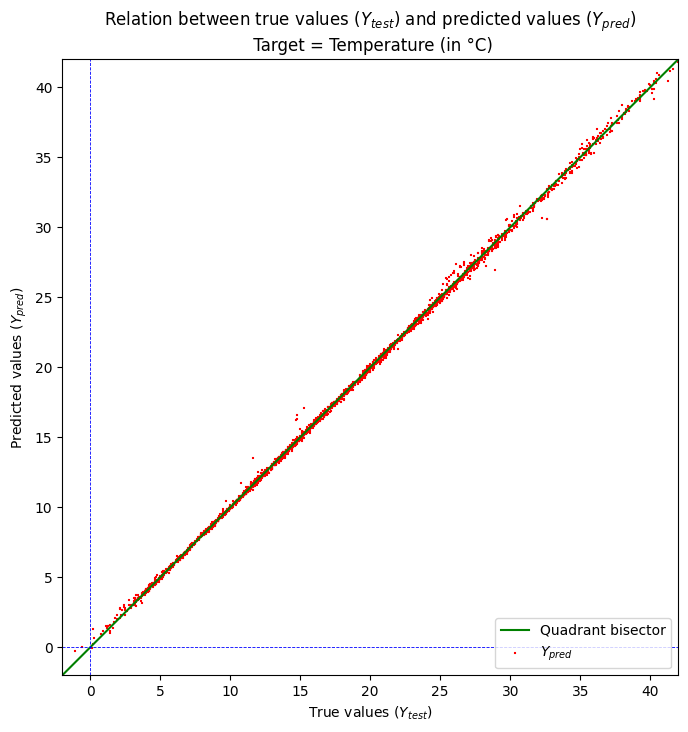

In [941]:
# Plotting the relation between the true values and the predicted ones
plt.figure(figsize=(12, 8))
plt.axes(aspect="equal")
plt.xlabel("True values ($Y_{test}$)")
plt.ylabel("Predicted values ($Y_{pred}$)")
plt.title("Relation between true values ($Y_{test}$) and predicted values ($Y_{pred}$)\n Target = Temperature (in °C)")
_, _ = plt.xlim([-2, 42]), plt.ylim([-2, 42])
plt.plot([-10, 50], [-10, 50], color="green", label="Quadrant bisector")
plt.scatter(Y_test, Y_pred, label="$Y_{pred}$", color="red", s = 1, marker ="+")
plt.axhline(y=0, color='b', lw=0.6, ls="--")
plt.axvline(x=0, color='b', lw=0.6, ls="--")
_ = plt.legend(loc="lower right")
plt.savefig("img/out.svg", dpi=600)

## NN model selection (experiments & simulations)

### Outline & Discussion

Since we have highly detailed the above cells, dedicated to design, fit and predict new values thanks to a Neural Network model, we now want to **precisely determine the best architecture** of our NN 

The following arguments will be tested in order to test a wide range of possible configurations:

We want to study the effect of the following hyper-parameters:
1. Number of layers
2. Number of neurons
3. $\eta$ : Learning rate
4. Presence of regularization techniques ($L_1$, $L_2$, ElasticNet).
5. Activation functions (ReLU, sigmoid function, $\tanh$, linear)


To do so, we follow the below protocol:
- We fix specific values (our discrete simulation mesh) by default to test, in order to prevent the model from being executed on too many non-relevant values.
- For each simulation, we observe the metrics values
- **WARNING**: For each simulation, we fix all the parameters except the one we want to see the effect on the global generalization capacity. 

**Remark**: Another solution consisting in varying several values at the same time in order to optimize is technically (memory, time, ...) and theoretically impossible

$\longrightarrow$ Even if moving only one parameter at the time is not really a significant method of simulation, this allows us to make a **relative** comparison with respect to the other values of that parameter inside a fixed configuration.

Once we find the most optimal model architecture thanks to the simulation with the above varying parameters, we can conduct a new simulation in order to quantify the effect/impact of :

6. Normalizing the dataset (`X_train` and `X_test`)
7. Noising the normalized dataset

**Remark**: We assume that the loss/cost function is fixed (`mse` in our case) but also the number of epochs (fixed to 15).


As it can be seen in the above section, designing, compiling, fitting, evaluating and predicting with the model can be a long task to be written and performed.

For shortness and simplicity sakes, we will develop and use in further developments the $4$ following functions:

1. `generate_model(...)` which designs and compiles the model.
2. `fit_model(...)` which fits the model with the training set
3. `plot_score_model(...)` which computes the scores/metrics and plot the main evolutions
4. `predict_model(...)` which predicts and compute several statistical indicators


We now write these highly-commented functions.

### General functions in order to automate the parameters comparison

In [1129]:
def generate_model(eta: float,
                  layers: list, # Input + Hidden layers
                  loss_function: str = "mae",
                  regularization: tuple = (0.0, 0.0)):
    """
    Function generating a new model, defining the network architecture and compiling it
    The returned object corresponds to the compiled model (keras.Sequential)
    """
    
    # Creation of the neural network
    model = Sequential()
    
    print("Defining the NN architecture")
    # Input layer
    nb_neurons = layers[0][0]
    activation_function = layers[0][1]
    model.add(
        Dense(nb_neurons, input_dim=X.shape[1], activation=activation_function)
    )
    
    # Hidden layers
    for layer in layers[1: ]:
        nb_neurons = layer[0]
        activation_function = layer[1]
        model.add(
            Dense(nb_neurons, 
                  activation=activation_function, 
                  kernel_regularizer=tf.keras.regularizers.L1L2(l1=regularization[0], 
                                                                l2=regularization[1])
                 )
        )

    # Output layer
    model.add(Dense(1, activation='linear'))

    # Setting up the optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=eta)

    # Early Stopping
    #es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="max")

    # Compiling the model
    print("Compiling the model")
    model.compile(loss=loss_function, 
                  optimizer=optimizer, 
                  metrics=["mse", "mae"]
                 )
    # Returning the model
    return model

In [1224]:
def fit_model(model, X_train_, Y_train_, NB_EPOCHS: int = 30, verbose: bool = False, X_test_ = X_test):
    """
    Function returning the results of the fitting model
    """
    # Fit step of the model
    print("Fitting the model")
    fit_start = time.time()
    history = model.fit(x=X_train_, 
                        y=Y_train_, 
                        epochs=NB_EPOCHS,
                        validation_data=(X_test_, Y_test),
                        #validation_split=0.3, # mettre validation_data avec X_test, Y_test
                        verbose=verbose,
                        #callbacks=[tqdm_callback], # [es, tqdm_callback],
                        batch_size=10,
                        #workers=8,
                        #use_multiprocessing=True
                       )
    fit_end = time.time()
    fit_dur = np.abs(fit_end - fit_start)
    print(f"Fitting duration: {fit_dur} sec")

    METRICS = model.metrics_names
    print(f"Metrics available: {METRICS}")
    return history

In [999]:
def plot_loss_score_model(model, history, X_test, Y_test, print_metrics=False):
    """
    Function returning the results of the 
    """
    # Gathering the output data from the fitting set
    history_df = pd.DataFrame(history.history)

    # To plot different metrics (if print_metrics is True)
    if print_metrics:
        print("Plotting the metrics evolution")
        ax = history_df.plot(subplots=True, figsize=(14,12), title="Evolution of the metrics through epochs")
        _ = [ax[k].set_xlabel("Epochs") for k in range(len(ax))]

    # Plotting the loss and validation loss
    print("Loss/Validation Loss evolution wrt the epochs")
    plt.figure()
    plt.plot(history_df['loss'], "r+-", label='Loss')
    plt.plot(history_df['val_loss'], "gx-", label='Validation Loss')
    plt.title("Loss and validation loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Evaluation on the test set with the same parameters (batch_size equal)
    print("Evaluation of the model")
    scores = model.evaluate(X_test, Y_test, batch_size=10, verbose=0)

    # Printing in a more human-friendly interface the different scores
    print("Gathering the scores")
    s = {k[1]:scores[0] for k in enumerate(model.metrics_names)}
    return s

In [1006]:
def predict_model(model, X_test, Y_test, plot_graphs: bool = False):
    """
    Function performing the prediction of the model
    """
    
    print("Computing the predictions wrt X_test")
    # Prediction on the test set
    Y_pred = model.predict(X_test).flatten()
        
    print("Computing the main metrics (MAE, MSE & RMSE)")
    # Computing the main prediction error arrays
    AE = np.abs(Y_pred - Y_test)           # Absolute Error
    SE = np.square(Y_pred - Y_test)        # Squared Error
    RSE = np.sqrt(SE)                      # Root Squared Error
    
    # Computing the main statistical indicators
    MAE = np.mean(AE)                      # Mean Absolute Error
    MSE = np.mean(SE)                      # Mean Squared Error
    RMSE = np.sqrt(MSE)                    # Root Mean Squared Error
    
    # Storing the results in a dictionary
    scores = {"MAE": MAE, "MSE": MSE, "RMSE": RMSE}
    
    # Computing the "Within k-sigma" ranges where k \in {1, 2, 3}
    print("Computing the 'Within k-sigma' ranges where k \in {1, 2, 3}")
    within_sigma = {k:np.sum(np.abs(Y_pred - Y_test.to_numpy()) < k*RMSE) for k in [0.5, 1, 2, 3, 6]}  

    # Plotting the graphs
    if plot_graphs:
        print("Plotting the graphs")
        # Plot of the distribution of the Prediction error
        plt.figure()
        _ = plt.hist(Y_pred - Y_test, bins = 600, color="blue")
        _ = plt.title("Prediction error histogram (distribution)")
        _, _ = plt.xlabel("Bins"), plt.ylabel("# of samples")
        
        # Plot the "Within k-sigma" ranges where k \in {1, 2, 3}
        plt.figure(figsize=(13, 6))
        _ = plt.barh(range(len(within_sigma)), 
                    list(within_sigma.values()), 
                    align='center', color=["yellow", "orange", "red", "purple", "green"])
        _ = plt.yticks(range(len(within_sigma)), 
                       list(["$\sigma$ = " + str(k) for k in within_sigma.keys()]))
        for i, v in enumerate(within_sigma.values()):
            _ = plt.text(500, i, f"$\longrightarrow$ {v} samples within {list(within_sigma)[i]}$\sigma$", color='black', va="center")

        plt.axvline(x=Y_test.shape[0], color='b', lw=0.6, ls="--")
        plt.text(x=Y_test.shape[0] - 100, y = -0.9, s="TOTAL SIZE", color="blue")
        _ = plt.title(f"# of predicted values within $\sigma$ [distribution]\nTotal # of test samples: {Y_test.shape[0]}")
        
        # Histogram of errors
        plt.figure(figsize=(10, 8))
        plt.title("Distribution of the RSE (Histogram)")
        _, _, _ = (plt.hist(RSE, bins=100, color="blue"),
                   plt.xlabel("RSE's bins"),
                   plt.ylabel("# of samples matching the bins")
                  )
        
        # Plotting the relation between the true values and the predicted ones
        plt.figure(figsize=(12, 8))
        plt.axes(aspect="equal")
        plt.xlabel("True values ($Y_{test}$)")
        plt.ylabel("Predicted values ($Y_{pred}$)")
        plt.title("Relation between true values ($Y_{test}$) and predicted values ($Y_{pred}$)\n Target = Temperature (in °C)")
        _, _ = plt.xlim([-2, 42]), plt.ylim([-2, 42])
        plt.plot([-10, 50], [-10, 50], color="green", label="Quadrant bisector")
        plt.scatter(Y_test, Y_pred, label="$Y_{pred}$", color="red", s = 1, marker ="+")
        plt.axhline(y=0, color='b', lw=0.6, ls="--")
        plt.axvline(x=0, color='b', lw=0.6, ls="--")
        _ = plt.legend(loc="lower right")
        plt.savefig("img/out.svg", dpi=600)
        
    return {"scores": scores, "sigma-intervals": within_sigma}

In [1098]:
def show_architecture_model(model):
    """
    Function creating, showing and saving on disk the NN model architecture
    """
    dt = datetime.datetime.now().strftime("%d/%m/%Y_%H:%M:%S")
    filename = f"out_{dt}"
    print(filename)
    plot_model(model,
               to_file=f"img/{filename}_A.png",
               rankdir="LR")
    visualizer(model, 
               filename=f"img/{filename}_B", 
               format="png", 
               view=False
              )
    Image(f"img/{filename}_A.png")

We can test the chain of these functions by executing the following cell:

Defining the NN architecture
Compiling the model
Fitting the model


Training:   0%|     0/30 ETA: ?s,  ?epochs/s

Epoch 1/30


0/655                             ETA: ?s - 

Epoch 2/30


0/655                             ETA: ?s - 

Epoch 3/30


0/655                             ETA: ?s - 

Epoch 4/30


0/655                             ETA: ?s - 

Epoch 5/30


0/655                             ETA: ?s - 

Epoch 6/30


0/655                             ETA: ?s - 

Epoch 7/30


0/655                             ETA: ?s - 

Epoch 8/30


0/655                             ETA: ?s - 

Epoch 9/30


0/655                             ETA: ?s - 

Epoch 10/30


0/655                             ETA: ?s - 

Epoch 11/30


0/655                             ETA: ?s - 

Epoch 12/30


0/655                             ETA: ?s - 

Epoch 13/30


0/655                             ETA: ?s - 

Epoch 14/30


0/655                             ETA: ?s - 

Epoch 15/30


0/655                             ETA: ?s - 

Epoch 16/30


0/655                             ETA: ?s - 

Epoch 17/30


0/655                             ETA: ?s - 

Epoch 18/30


0/655                             ETA: ?s - 

Epoch 19/30


0/655                             ETA: ?s - 

Epoch 20/30


0/655                             ETA: ?s - 

Epoch 21/30


0/655                             ETA: ?s - 

Epoch 22/30


0/655                             ETA: ?s - 

Epoch 23/30


0/655                             ETA: ?s - 

Epoch 24/30


0/655                             ETA: ?s - 

Epoch 25/30


0/655                             ETA: ?s - 

Epoch 26/30


0/655                             ETA: ?s - 

Epoch 27/30


0/655                             ETA: ?s - 

Epoch 28/30


0/655                             ETA: ?s - 

Epoch 29/30


0/655                             ETA: ?s - 

Epoch 30/30


0/655                             ETA: ?s - 

Fitting duration: 24.609446048736572 sec
Metrics available: ['loss', 'mse', 'mae']
Loss/Validation Loss evolution wrt the epochs
Evaluation of the model
Gathering the scores
Computing the predictions wrt X_test
88/88 [==============================] - 0s 573us/step
Computing the main metrics (MAE, MSE & RMSE)
Computing the 'Within k-sigma' ranges where k \in {1, 2, 3}


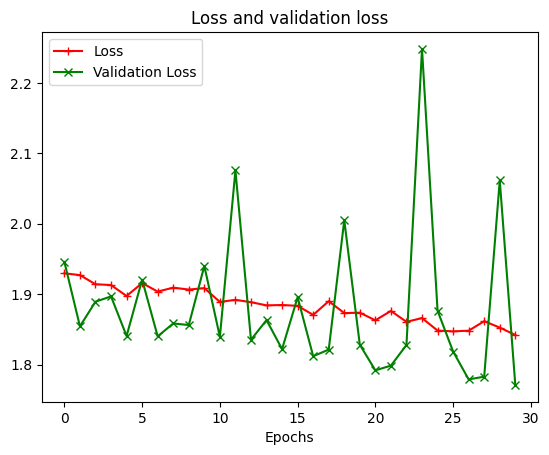

In [1100]:
model = generate_model(eta=2e-3, 
                   layers=[
                       (12, "relu"),
                       (10, "relu"),
                       (10, "relu"),
                       (10, "relu"),
                   ], loss_function="mse", regularization=(1, 1))

history = fit_model(model, X_train, Y_train)
plot_loss_score_model(model, history, X_test, Y_test, print_metrics=False)

prediction_results = predict_model(model, X_test, Y_test, False)
scores, sigmas = prediction_results["scores"], prediction_results["sigma-intervals"]

In [1122]:
scores, sigmas

({'MAE': 0.23942595725206778,
  'MSE': 0.12345237224425547,
  'RMSE': 0.351357897654593},
 {0.5: 1401, 1: 2198, 2: 2702, 3: 2771, 6: 2803})

### Conclusion about the optimal model

We finally consider a Neural Network model composed of:
- 5 layers
- 10 neurons per layer
- $\eta \simeq 2\times 10^{—3}$ (learning rate)
- $L_1$ or $L_2$ regularization
- **ReLU** as activation function for each layer

### Impact of normalization

We know want to quantify the impact of normalization and noise. 
To do so, we conduct three simulations given our final model:

1. One on non-normalized data
2. One on normalized data
3. One on normalized **and noised** data


We modify the `fit_model` function to be adapted to the change of `X_train` (check 

Defining the NN architecture
Compiling the model
Fitting the model
Fitting duration: 10.559200048446655 sec
Metrics available: ['loss', 'mse', 'mae']
Loss/Validation Loss evolution wrt the epochs
Evaluation of the model
Gathering the scores
Computing the predictions wrt X_test
88/88 [==============================] - 0s 617us/step
Computing the main metrics (MAE, MSE & RMSE)
Computing the 'Within k-sigma' ranges where k \in {1, 2, 3}
Plotting the graphs
{'MAE': 2.6248880886352106, 'MSE': 10.840426682457467, 'RMSE': 3.292480323776813} {0.5: 1008, 1: 1959, 2: 2678, 3: 2792, 6: 2808}


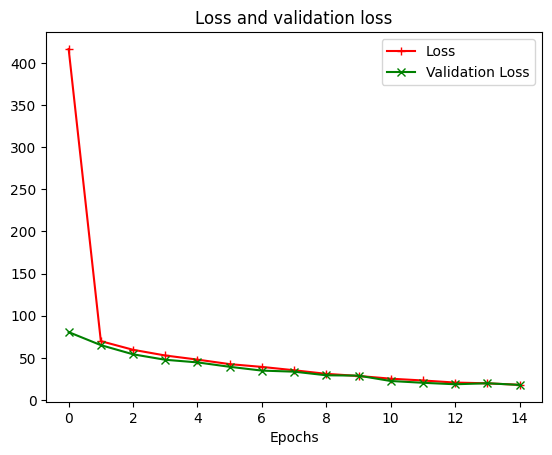

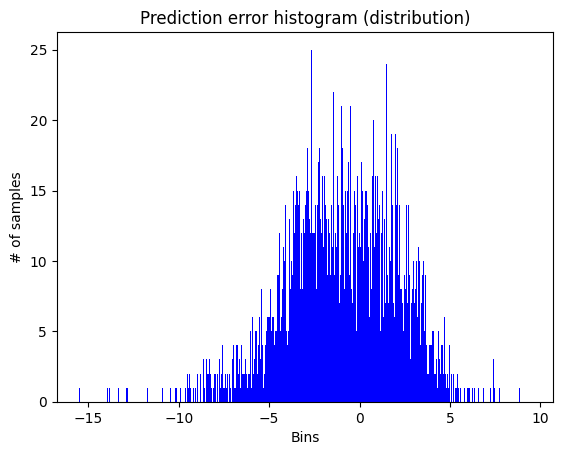

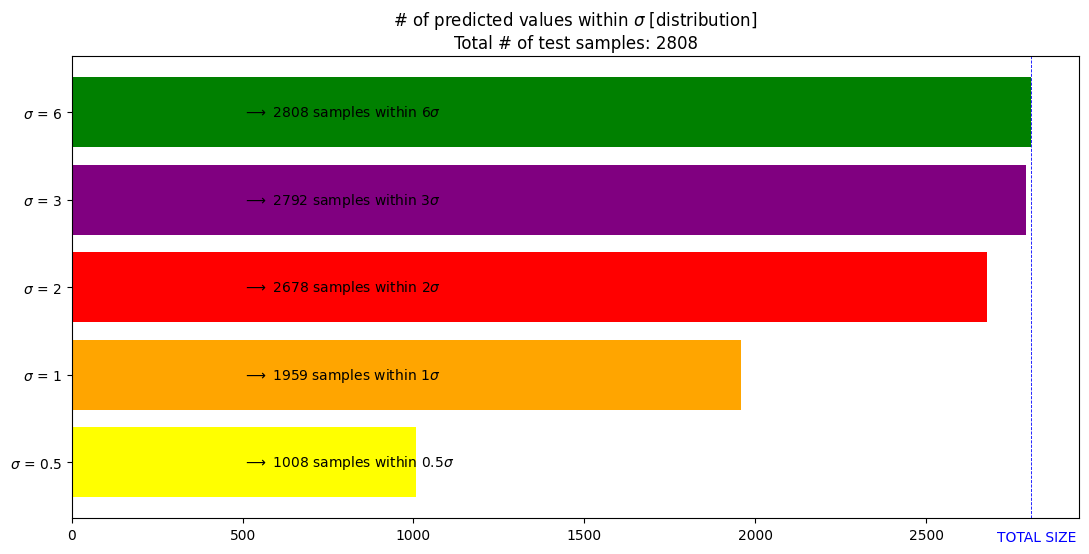

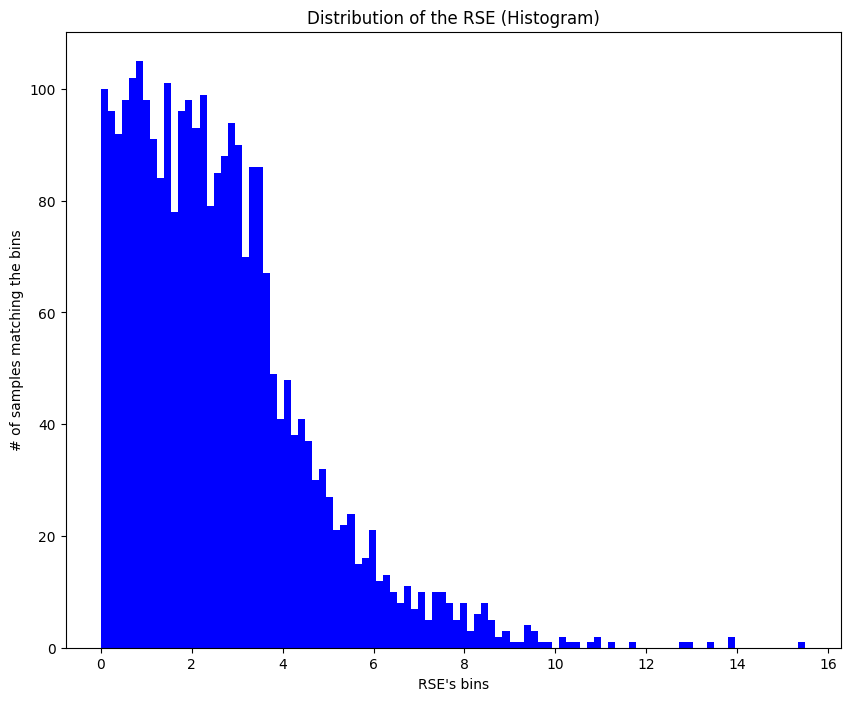

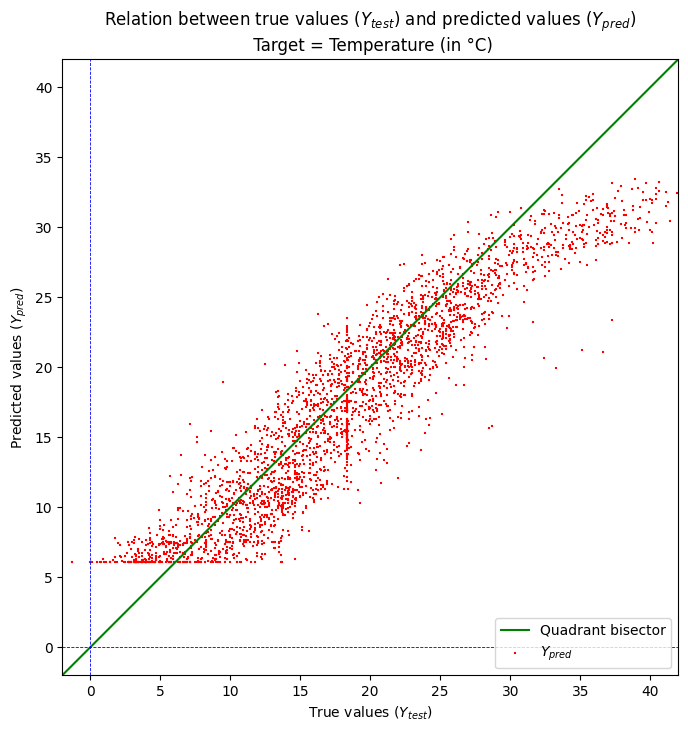

In [1231]:
# Non-normalized
model = generate_model(eta=5e-3, 
                       layers=[(10, "relu") for _ in range(5)], 
                       loss_function="mse", 
                       regularization=(1, 0))

history = fit_model(model, X_train_no_norm, Y_train, NB_EPOCHS=15, X_test_=X_test_no_norm)
plot_loss_score_model(model, history, X_test_no_norm, Y_test, print_metrics=False)
prediction_results = predict_model(model, X_test_no_norm, Y_test, True)
scores, sigmas = prediction_results["scores"], prediction_results["sigma-intervals"]
print(scores, sigmas)

Defining the NN architecture
Compiling the model
Fitting the model
Fitting duration: 14.790411949157715 sec
Metrics available: ['loss', 'mse', 'mae']
Loss/Validation Loss evolution wrt the epochs
Evaluation of the model
Gathering the scores
Computing the predictions wrt X_test
88/88 [==============================] - 0s 685us/step
Computing the main metrics (MAE, MSE & RMSE)
Computing the 'Within k-sigma' ranges where k \in {1, 2, 3}
Plotting the graphs
{'MAE': 0.6212148011868747, 'MSE': 0.6941917480937397, 'RMSE': 0.8331817017276242} {0.5: 1162, 1: 2124, 2: 2708, 3: 2764, 6: 2805}


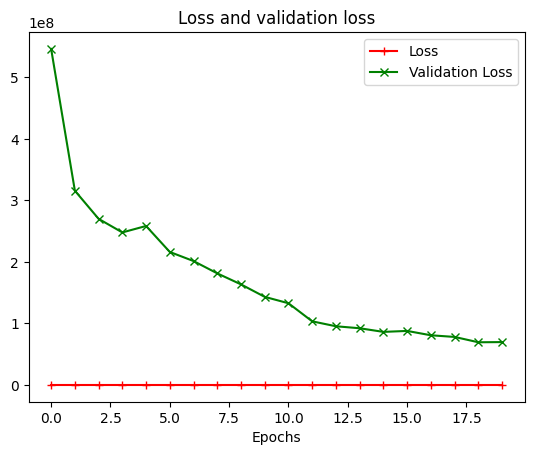

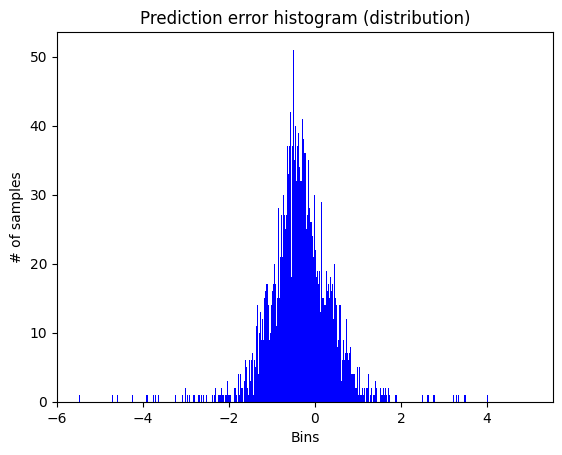

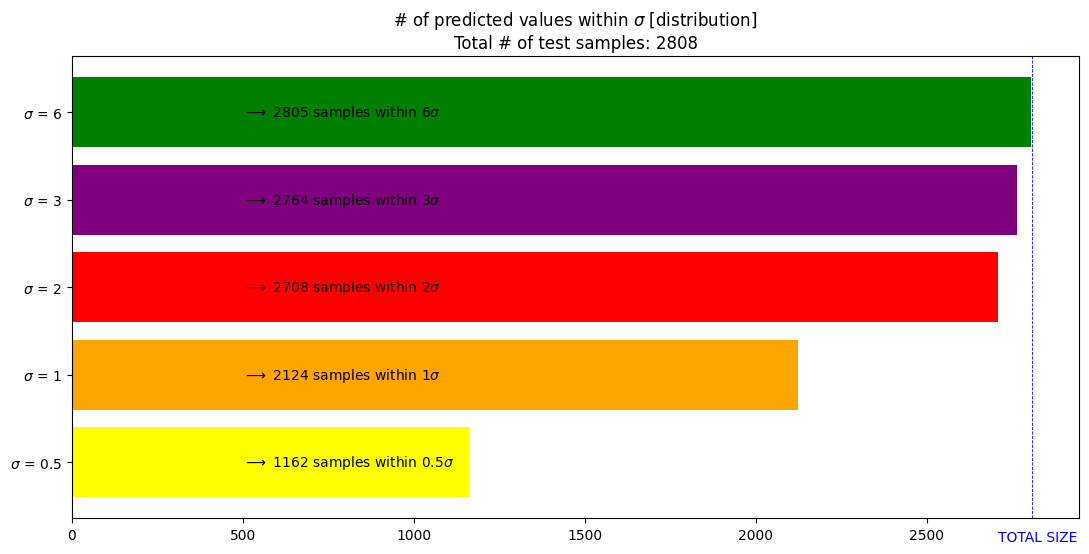

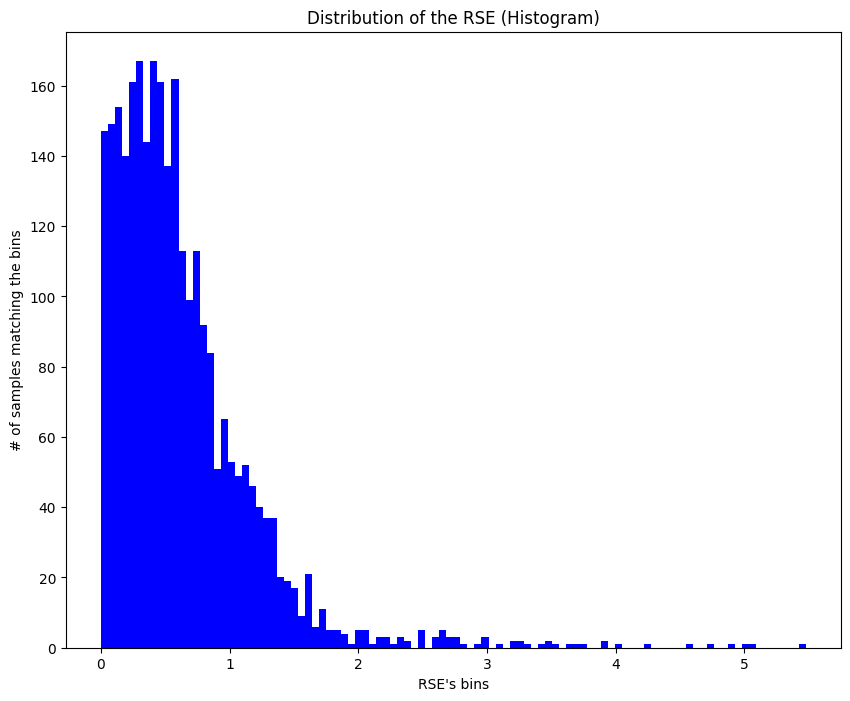

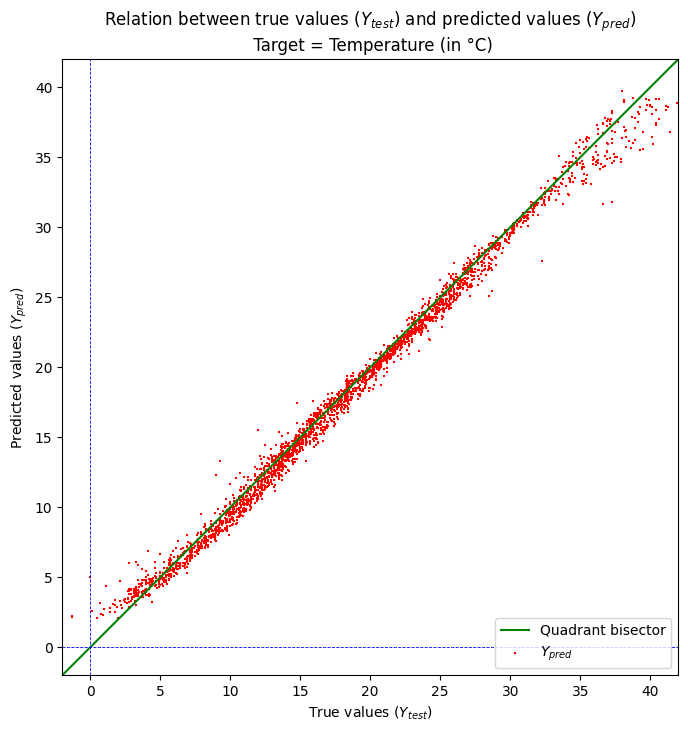

In [1232]:
# Normalized data
model = generate_model(eta=5e-3, 
                       layers=[(10, "relu") for _ in range(5)], 
                       loss_function="mse", 
                       regularization=(1, 0))

history = fit_model(model, X_train, Y_train, NB_EPOCHS=20, X_test_=X_test_no_norm)
plot_loss_score_model(model, history, X_test, Y_test, print_metrics=False)
prediction_results = predict_model(model, X_test, Y_test, True)
scores, sigmas = prediction_results["scores"], prediction_results["sigma-intervals"]
print(scores, sigmas)

**Observations**: We can see that the RMSE computed on the predicted values from the normalized dataset is clearly lower than the on non-normalized data.

In addition, the predicted values from the graph are, for most of them, really far from the quadrant bisector.

Finally, the histograms showing the predictive error distributions seem to represent some **heavy-tailed** distributions, synonym of large prediction errors as output of the model.

$\longrightarrow$ This sheds light on the importance of implementing a normalized scaler before any ML/DL technique implementation.

### Noise impact after normalization

We want to study the impact of noising the train dataset **after normalization**.

In order to do so, we declare a function tailored to **noise** the features.


**Noising strategy**: For the $i$-th feature within the training set


$$X_i \longleftarrow \alpha X_i + \beta\mathcal{N}(0, \sigma_i) + \gamma $$

where $\sigma_i$ represents the variance of the feature $i$, $\alpha$, $\beta$ and $\gamma$ two real numbers.


**Remark**: We have chosen to noise **ONLY** the training set. We keep the test set unchanged for the same reason we left it unchanged while we were deciding to handle or not outliers.

In [1233]:
def noising_features(X):
    """
    Function generating and applying a noised version on all the features of a given dataset
    """
    # Defining the global variables
    alpha = 1.04
    beta = 4
    gamma = - 0.007
    
    # Deepcopying the features (for security reason)
    d = copy.deepcopy(X)
    
    # Iterating on each feature
    for c in range(X.shape[1]):
        # Computing the variance of the feature
        std_col = np.var(d[:, c])
        
        # Computing the additive part of the noise
        d[:, c] = np.random.normal(0, beta*std_col, size=(X.shape[0],))
    
    # Applying and returning the final noise
    return alpha*X + d + gamma

We can apply that function on our `X_train` and plot the relation between `X_train_noise` and `X_train`:

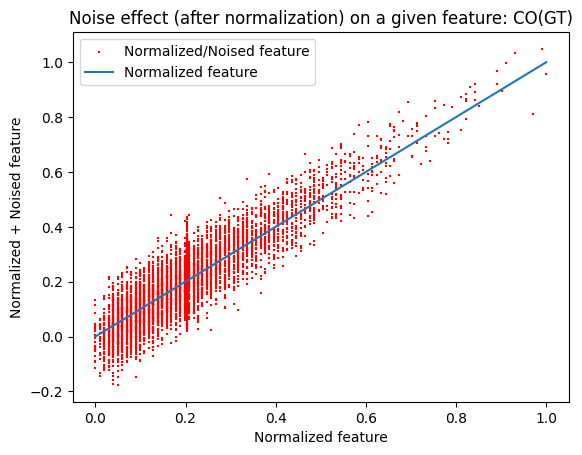

In [1235]:
# Computing the noisy features
X_train_noise = noising_features(X_train)

# Plotting the results
_ = plt.scatter(X_train.T[0],X_train_noise.T[0],s=2, marker='+' ,c="r", label="Normalized/Noised feature")
x = np.linspace(0, 1, 100)
_ = plt.plot(x,x, label="Normalized feature")
plt.xlabel("Normalized feature")
plt.ylabel("Normalized + Noised feature")
_ = plt.title("Noise effect (after normalization) on a given feature: CO(GT)")
_ = plt.legend()

We can also estimate the difference element-wise speaking:

In [1237]:
pd.DataFrame(X_train_noise - X_train)

,0,1,2,3,4,5,6,7,8,9
0,-0.049406,0.036431,-0.063014,0.073138,0.052749,0.148869,0.033442,0.092106,0.084101,-0.481308
1,0.106687,0.006412,0.007963,-0.072432,0.026995,0.116359,-0.066571,-0.020397,-0.607901,-0.062235
2,0.110076,0.072411,-0.041021,0.093108,-0.063759,0.045070,0.032161,-0.008614,0.316091,0.427357
3,-0.091684,0.177200,-0.098830,0.028009,0.122503,0.090096,-0.079234,0.194270,0.143125,0.599006
4,0.198007,0.134677,-0.047826,0.072693,-0.123141,-0.003391,-0.129441,-0.094270,0.153147,-0.540154
...,...,...,...,...,...,...,...,...,...,...
6544,-0.112385,0.016609,-0.043824,-0.066795,0.082251,-0.049646,-0.414145,-0.028812,-0.199612,0.046098
6545,0.041931,-0.155051,-0.110714,-0.037668,-0.049272,-0.151986,0.023255,0.296980,-1.180520,0.115326
6546,0.060582,0.222873,-0.008957,0.092772,0.110558,-0.065444,-0.063000,-0.003371,0.224705,0.610260
6547,0.059585,0.123012,0.059050,-0.047011,0.004147,0.108292,0.032828,0.115559,-0.887747,-0.255459


We can now apply our optimal model to the `X_train_noise`:

Defining the NN architecture
Compiling the model
Fitting the model
Fitting duration: 17.940953016281128 sec
Metrics available: ['loss', 'mse', 'mae']
Loss/Validation Loss evolution wrt the epochs
Evaluation of the model
Gathering the scores
Computing the predictions wrt X_test
88/88 [==============================] - 0s 1ms/step
Computing the main metrics (MAE, MSE & RMSE)
Computing the 'Within k-sigma' ranges where k \in {1, 2, 3}
Plotting the graphs
{'MAE': 2.5458742793582823, 'MSE': 12.131834635058224, 'RMSE': 3.483078327436554} {0.5: 1316, 1: 2133, 2: 2643, 3: 2755, 6: 2808}


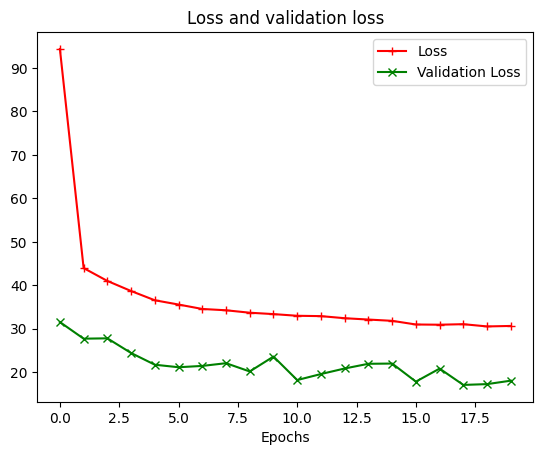

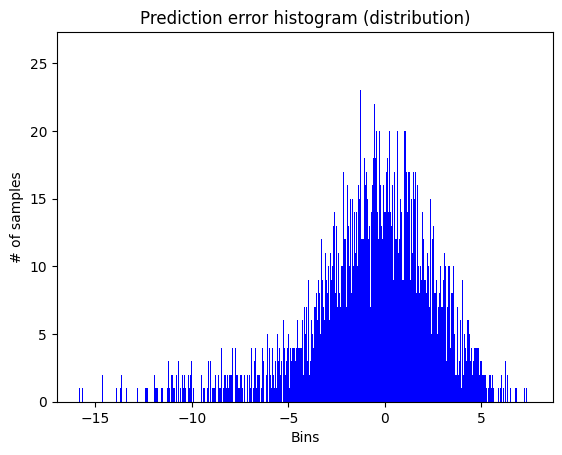

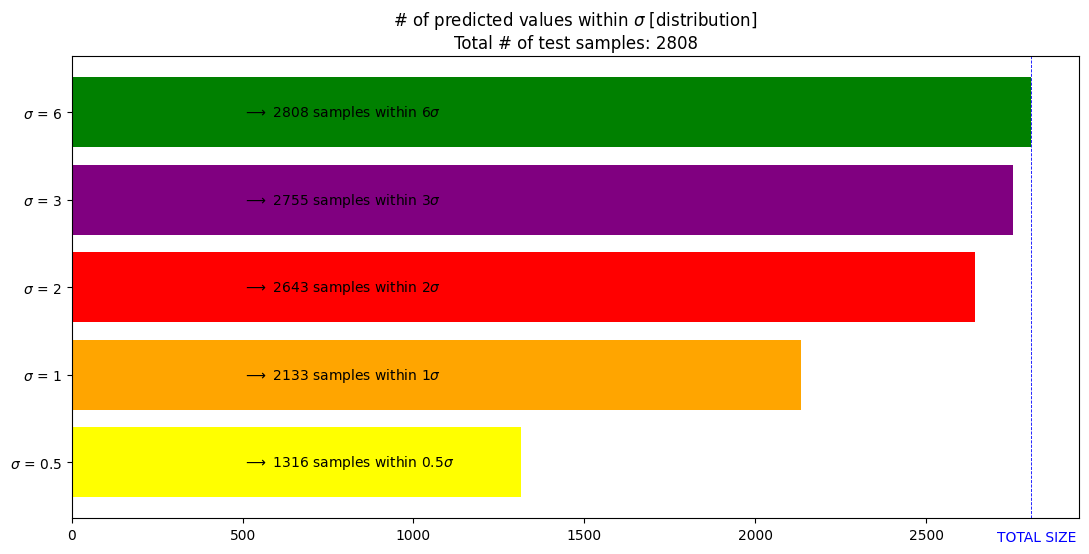

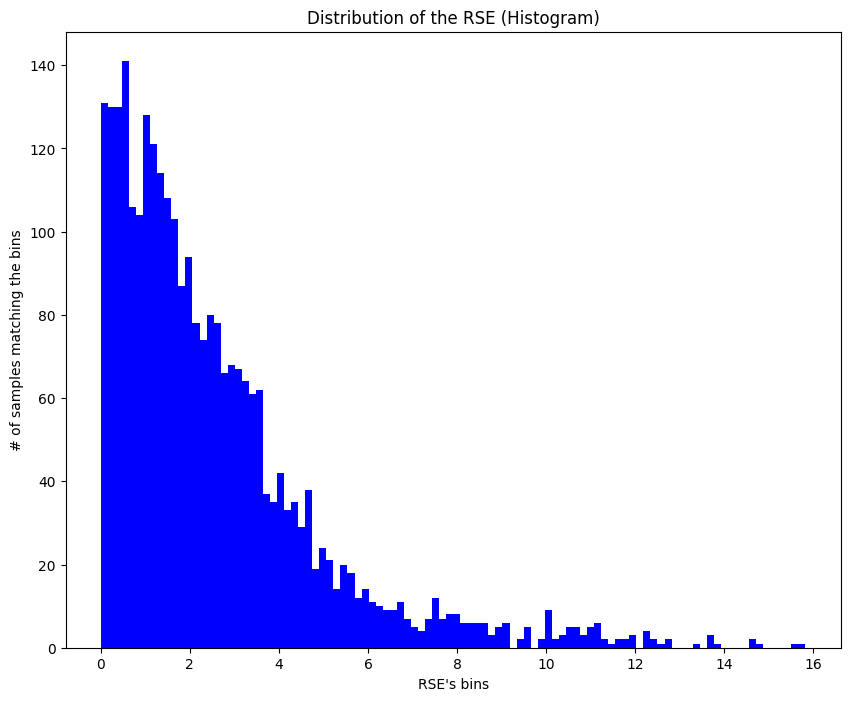

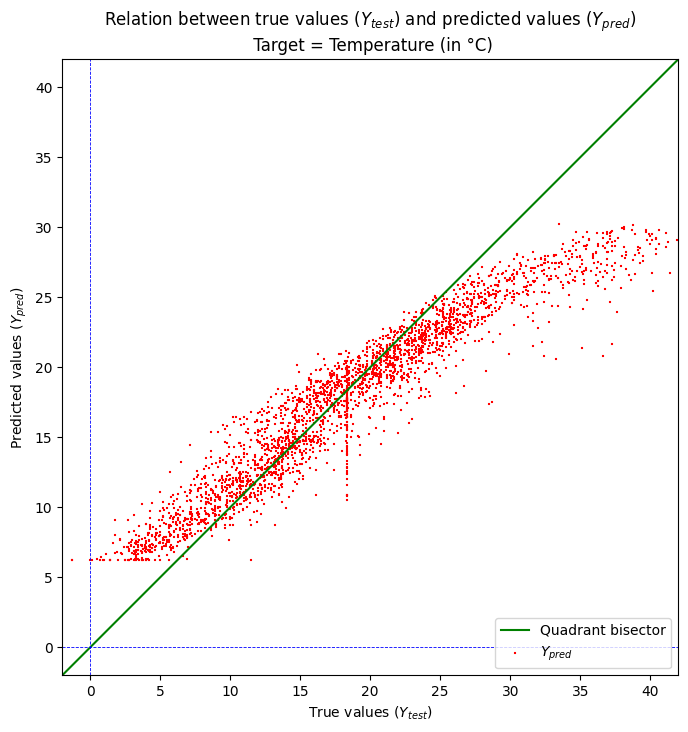

In [1239]:
# Noised + Normalized data
model = generate_model(eta=5e-3, 
                       layers=[(10, "relu") for _ in range(5)], 
                       loss_function="mse", 
                       regularization=(1, 0))

history = fit_model(model, X_train_noise, Y_train, NB_EPOCHS=20)
plot_loss_score_model(model, history, X_test, Y_test, print_metrics=False)
prediction_results = predict_model(model, X_test, Y_test, True)
scores, sigmas = prediction_results["scores"], prediction_results["sigma-intervals"]
print(scores, sigmas)

We can see on the final graph (Predicted values as a function of the real values) that the noise effect makes the predictive power of our model worse. This can also


That's why the process of inserting some noise has good predictive property only if the model initially over-fits the observations. While this is not the case originally, we can conclude that inserting an additional noise on the `X_train` set is not a good idea and has a negative impact on the predictions.

## Conclusion

This practical has given us the opportunity to determine the parameters values for optimal NN architecture, but also to deal with TensorFlow/Keras libraries.

---

**Lucas RODRIGUEZ** (Sep. - Oct. 2022)